In [1]:
# CELL 0 : import library
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# import lightgbm as lgb 
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
# from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
# CELL 2 : load data
# load dataset
df_clean = pd.read_csv('1_hotel_bookings_prepared.csv')
df_clean.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_nights,total_people,weekend_ratio,booking_complexity,customer_reliability,lead_time_category,season,is_peak_season
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,0,0,0,C,3,No Deposit,0.0,0,Transient,0.0,0,0,0,2.0,0.0,3,0.0,Long,Summer,1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,0,0,0,C,4,No Deposit,0.0,0,Transient,0.0,0,0,0,2.0,0.0,4,0.0,Very_Long,Summer,1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,0,0,0,A,0,No Deposit,0.0,0,Transient,75.0,0,0,1,1.0,0.0,0,0.0,Very_Short,Summer,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,0,0,0,A,0,No Deposit,304.0,0,Transient,75.0,0,0,1,1.0,0.0,0,0.0,Short,Summer,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,0,0,0,A,0,No Deposit,240.0,0,Transient,98.0,0,1,2,2.0,0.0,1,0.0,Short,Summer,1


In [3]:
df_cancel = df_clean[df_clean['is_canceled'] == 1]
df_not_cancel = df_clean[df_clean['is_canceled'] == 0]

In [4]:
# CELL 3: Dataset Overview dan Basic Statistics
print("="*60)
print("DATASET OVERVIEW - HOTEL BOOKING CANCELLATION ANALYSIS")
print("="*60)

# Basic info
print(f"\n📊 Dataset Shape: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")
print(f"📅 Memory Usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Missing values check
missing_values = df_clean.isnull().sum()
if missing_values.sum() > 0:
    print(f"\n⚠️  Missing Values: {missing_values.sum()} total")
    print(missing_values[missing_values > 0])
else:
    print("\n✅ No missing values found!")

# Target variable distribution
print(f"\n🎯 Target Variable Distribution (is_canceled):")
target_dist = df_clean['is_canceled'].value_counts()
target_pct = df_clean['is_canceled'].value_counts(normalize=True) * 100
print(f"   • Not Canceled (0): {target_dist[0]:,} ({target_pct[0]:.1f}%)")
print(f"   • Canceled (1): {target_dist[1]:,} ({target_pct[1]:.1f}%)")

print(f"\n📈 Data Types:")
print(df_clean.dtypes.value_counts())

print(f"\n🔢 Numerical Features Summary:")
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"   Total numerical features: {len(numerical_cols)}")

print(f"\n📝 Categorical Features Summary:")
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
print(f"   Total categorical features: {len(categorical_cols)}")

print("\n" + "="*60)

DATASET OVERVIEW - HOTEL BOOKING CANCELLATION ANALYSIS

📊 Dataset Shape: 87,396 rows × 35 columns
📅 Memory Usage: 62.76 MB

⚠️  Missing Values: 456 total
children      4
country     452
dtype: int64

🎯 Target Variable Distribution (is_canceled):
   • Not Canceled (0): 63,371 (72.5%)
   • Canceled (1): 24,025 (27.5%)

📈 Data Types:
int64      19
object     10
float64     6
Name: count, dtype: int64

🔢 Numerical Features Summary:
   Total numerical features: 25

📝 Categorical Features Summary:
   Total categorical features: 10



## **Booking Cancelation Analysis**

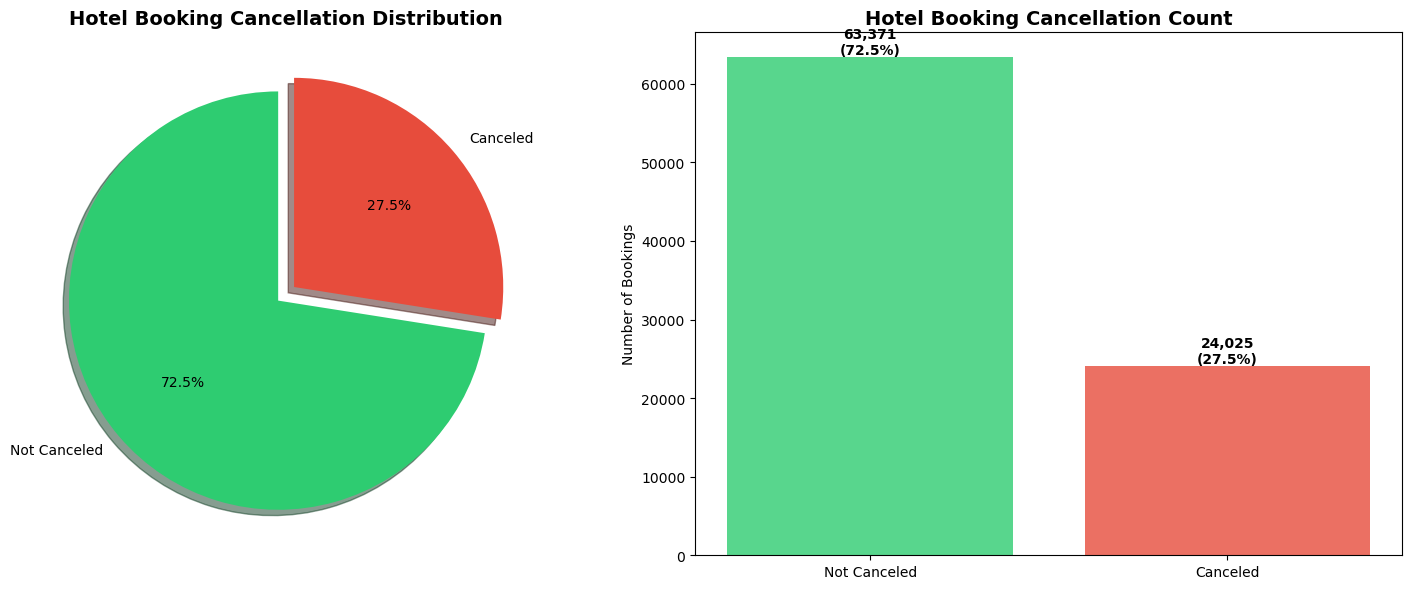

🔍 KEY INSIGHTS:
   • Cancellation Rate: 27.5%
   • ⚡ Moderate cancellation rate - room for improvement


In [5]:
# CELL 4: Target Variable Analysis - Cancellation Overview
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Cancellation rate pie chart
labels = ['Not Canceled', 'Canceled']
sizes = df_clean['is_canceled'].value_counts()
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode,
            shadow=True, startangle=90)
axes[0].set_title('Hotel Booking Cancellation Distribution', fontsize=14, fontweight='bold')

# Cancellation rate bar chart
ax1 = axes[1]
bars = ax1.bar(['Not Canceled', 'Canceled'], sizes, color=colors, alpha=0.8)
ax1.set_title('Hotel Booking Cancellation Count', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Bookings')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}\n({sizes[i]/sizes.sum()*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Key insights
print("🔍 KEY INSIGHTS:")
cancellation_rate = df_clean['is_canceled'].mean() * 100
print(f"   • Cancellation Rate: {cancellation_rate:.1f}%")
if cancellation_rate > 30:
    print("   • ⚠️  High cancellation rate - needs attention!")
elif cancellation_rate > 20:
    print("   • ⚡ Moderate cancellation rate - room for improvement")
else:
    print("   • ✅ Low cancellation rate - performing well")

Proporsi data menunjukkan bahwa customer lebih cenderung untuk tidak melakukan cacel booking dibandingkan dengan melakukan cancel, Namun perlu dicari lebih lanjut alasan kenapa kasus Cancel banyak terjadi dengan proporsi sebesar 27% dari data

## **Hotel Distribution Analysis**

In [6]:
df_cancel = df_clean[df_clean['is_canceled'] == 1]
df_not_cancel = df_clean[df_clean['is_canceled'] == 0]

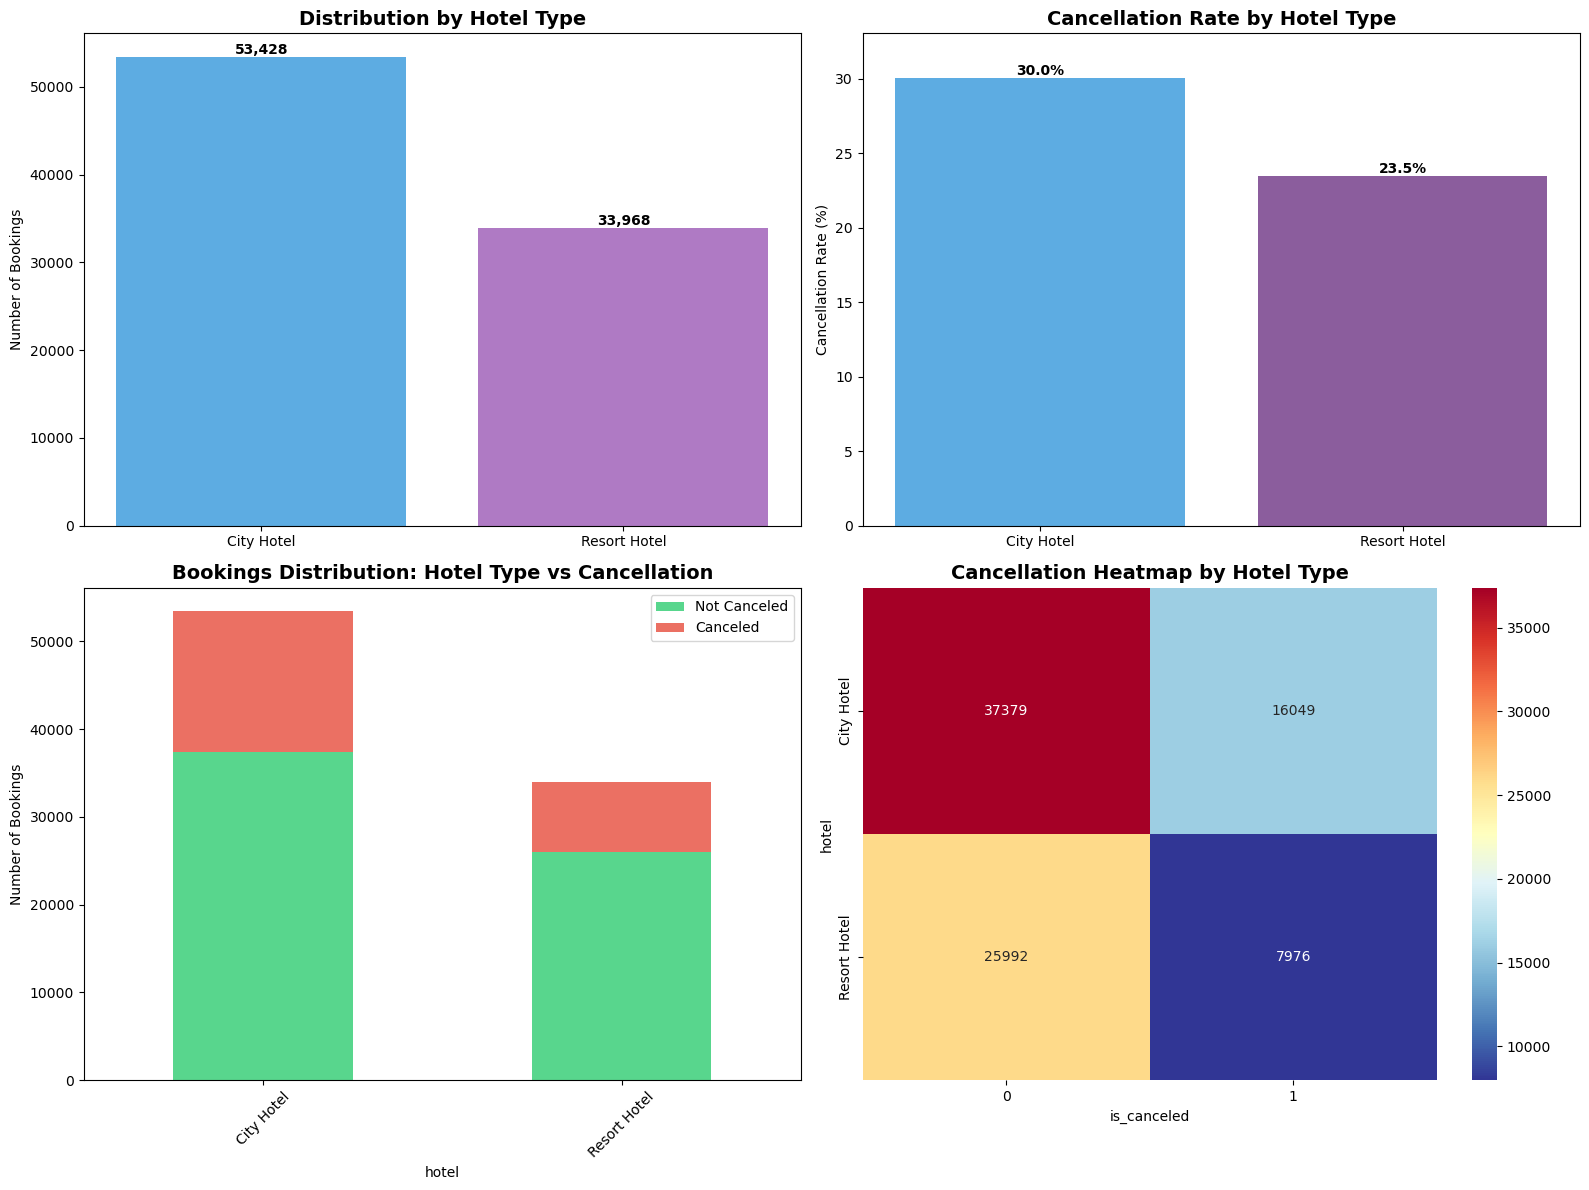

🏨 HOTEL TYPE INSIGHTS:
   • City Hotel: 30.0% cancellation rate (53,428 bookings)
   • Resort Hotel: 23.5% cancellation rate (33,968 bookings)

   🏆 Best performing: Resort Hotel
   ⚠️  Needs attention: City Hotel


In [7]:
# CELL 5: Hotel Type Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Hotel type distribution
hotel_counts = df_clean['hotel'].value_counts()
axes[0,0].bar(hotel_counts.index, hotel_counts.values, color=['#3498db', '#9b59b6'], alpha=0.8)
axes[0,0].set_title('Distribution by Hotel Type', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Number of Bookings')
for i, v in enumerate(hotel_counts.values):
    axes[0,0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Cancellation rate by hotel type
cancel_by_hotel = df_clean.groupby('hotel')['is_canceled'].agg(['count', 'sum', 'mean']).reset_index()
cancel_by_hotel['cancel_rate'] = cancel_by_hotel['mean'] * 100

bars = axes[0,1].bar(cancel_by_hotel['hotel'], cancel_by_hotel['cancel_rate'], 
                     color=['#3498db', "#6E3485"], alpha=0.8)
axes[0,1].set_title('Cancellation Rate by Hotel Type', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Cancellation Rate (%)')
axes[0,1].set_ylim(0, max(cancel_by_hotel['cancel_rate']) * 1.1)
for i, v in enumerate(cancel_by_hotel['cancel_rate']):
    axes[0,1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Stacked bar chart - bookings by hotel and cancellation status
hotel_cancel_cross = pd.crosstab(df_clean['hotel'], df_clean['is_canceled'])
hotel_cancel_cross.plot(kind='bar', stacked=True, ax=axes[1,0], color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[1,0].set_title('Bookings Distribution: Hotel Type vs Cancellation', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Number of Bookings')
axes[1,0].legend(['Not Canceled', 'Canceled'])
axes[1,0].tick_params(axis='x', rotation=45)

# Heatmap of hotel type vs cancellation
cancel_matrix = df_clean.groupby(['hotel', 'is_canceled']).size().unstack(fill_value=0)
sns.heatmap(cancel_matrix, annot=True, fmt='d', cmap='RdYlBu_r', ax=axes[1,1])
axes[1,1].set_title('Cancellation Heatmap by Hotel Type', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Key insights
print("🏨 HOTEL TYPE INSIGHTS:")
for idx, row in cancel_by_hotel.iterrows():
    hotel_type = row['hotel']
    cancel_rate = row['cancel_rate']
    total_bookings = row['count']
    print(f"   • {hotel_type}: {cancel_rate:.1f}% cancellation rate ({total_bookings:,} bookings)")
    
best_hotel = cancel_by_hotel.loc[cancel_by_hotel['cancel_rate'].idxmin(), 'hotel']
worst_hotel = cancel_by_hotel.loc[cancel_by_hotel['cancel_rate'].idxmax(), 'hotel']
print(f"\n   🏆 Best performing: {best_hotel}")
print(f"   ⚠️  Needs attention: {worst_hotel}")

In [8]:
df_cancel = df_clean[df_clean['is_canceled'] == 1]
df_not_cancel = df_clean[df_clean['is_canceled'] == 0]

In [9]:
df_hotel = pd.DataFrame({
    'Jumlah': df_clean['hotel'].value_counts(),
    'Proporsi (%)': df_clean['hotel'].value_counts(normalize=True) * 100,
    'Cancelation_rate': df_clean.groupby('hotel')['is_canceled'].mean() * 100,
    'Total Cancelations': df_clean.groupby('hotel')['is_canceled'].sum(),
    'Adr Mean Cancel': df_cancel.groupby('hotel')['adr'].mean(),
    'Adr Mean Not Cancel': df_not_cancel.groupby('hotel')['adr'].mean()
}).reset_index()

df_hotel.rename(columns={'index': 'Stay Category'}, inplace=True)
display(df_hotel.sort_values(by='Proporsi (%)', ascending=False))

,hotel,Jumlah,Proporsi (%),Cancelation_rate,Total Cancelations,Adr Mean Cancel,Adr Mean Not Cancel
0,City Hotel,53428,61.133233,30.038557,16049,117.276632,108.284982
1,Resort Hotel,33968,38.866767,23.480923,7976,118.770194,92.966370


berdasarkan beberapa grafik yang telah ditampilkan, terlihat bahwa nilai `cancelation rate` pada hotel dengan jenis **city hotel** lebih tinggi dibandingkan dengan **resort hotel**. Hal ini bisa terjadi akibat jumlah distribusi hotelnya memang cenderung lebih banyak pada **city hotel**. Alasan lain yang dapat menguatkan kejadian ini adalah **city hotel** yang tentunya terletak di kota memiliki lebih banyak saingan dibandingkan dengan **resort hotel**. Hal ini umum terjadi karena pada perkotaan memang lebih cenderung memiliki jumlah hotel yang lebih banyak dibandingkan daerah non perkotaan 

In [10]:
lead_cat_cancel = df_clean.groupby('lead_time_category')['is_canceled'].agg(['count', 'mean']).reset_index()
lead_cat_cancel['cancel_rate'] = lead_cat_cancel['mean'] * 100

In [11]:
lead_cat_cancel

,lead_time_category,count,mean,cancel_rate
0,Long,29443,0.367694,36.769351
1,Medium,22744,0.320084,32.008442
2,Short,16340,0.253672,25.367197
3,Very_Long,565,0.408850,40.884956
4,Very_Short,18304,0.084299,8.429851


## **Lead Time Analysis**

In [12]:
df_cancel = df_clean[df_clean['is_canceled'] == 1]
df_not_cancel = df_clean[df_clean['is_canceled'] == 0]

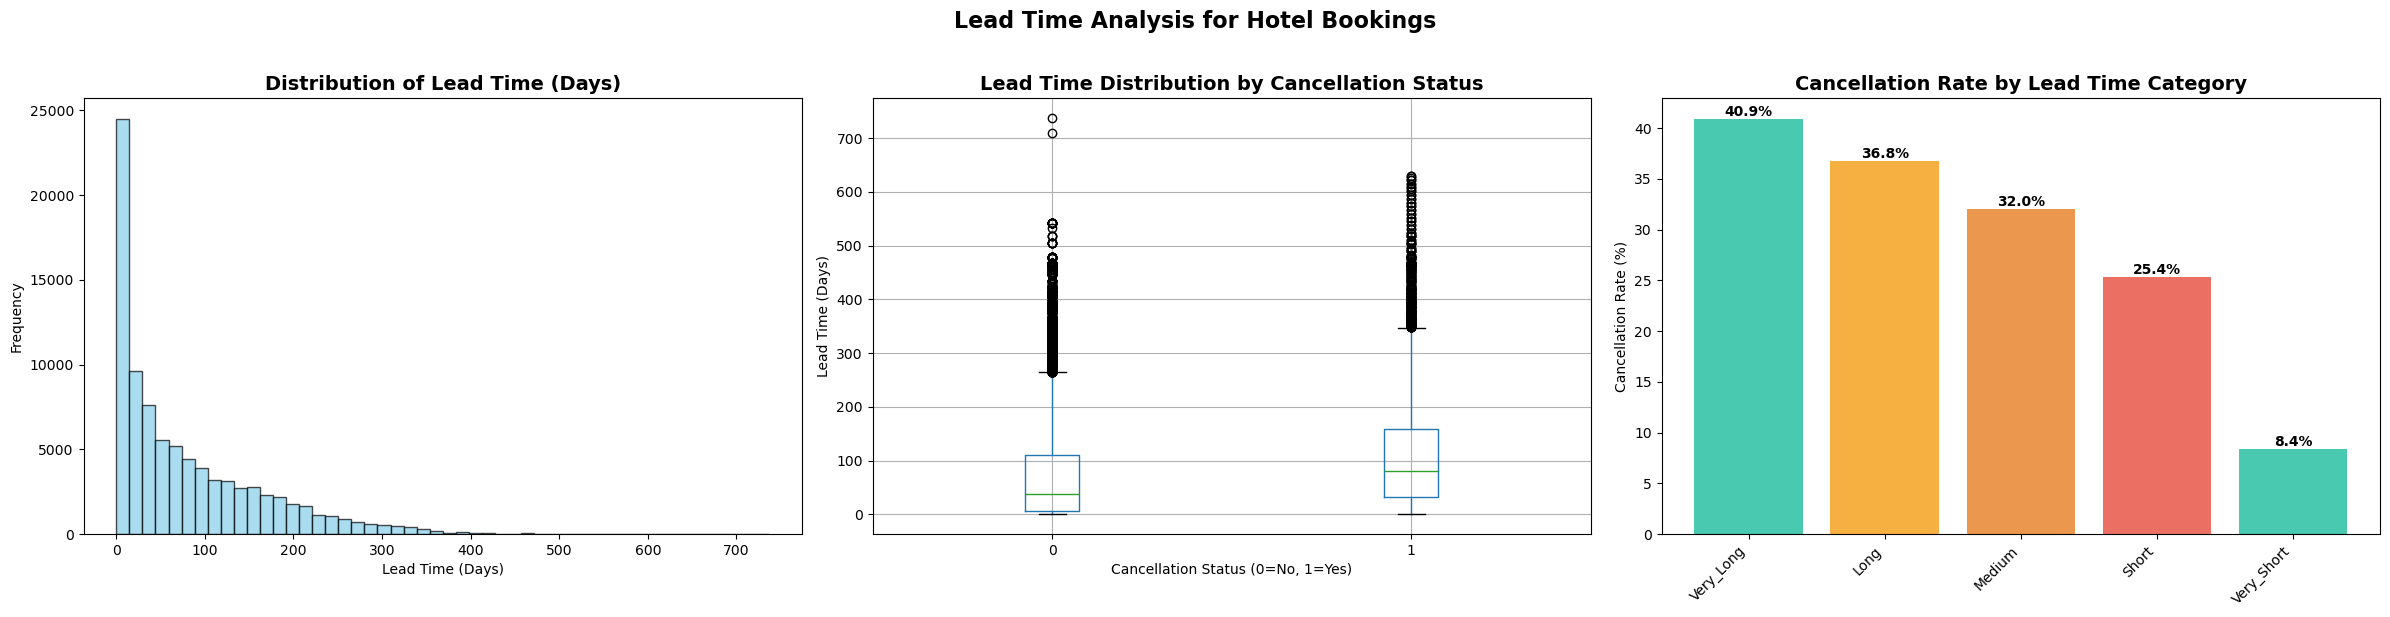

📅 LEAD TIME INSIGHTS:
   • Average lead time: 79.9 days
   • Median lead time: 49.0 days
   • Max lead time: 737 days
   • Very_Long: 40.9% cancellation rate (565 bookings)
   • Long: 36.8% cancellation rate (29,443 bookings)
   • Medium: 32.0% cancellation rate (22,744 bookings)
   • Short: 25.4% cancellation rate (16,340 bookings)
   • Very_Short: 8.4% cancellation rate (18,304 bookings)

   📊 Correlation with cancellation: 0.185
   • Moderate correlation - lead time has some effect on cancellation


In [13]:
# CELL 6: Booking Lead Time Analysis
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Lead time distribution
axes[0].hist(df_clean['lead_time'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Lead Time (Days)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lead Time (Days)')
axes[0].set_ylabel('Frequency')

# Box plot - Lead time by cancellation status
df_clean.boxplot(column='lead_time', by='is_canceled', ax=axes[1])
axes[1].set_title('Lead Time Distribution by Cancellation Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cancellation Status (0=No, 1=Yes)')
axes[1].set_ylabel('Lead Time (Days)')

lead_cat_cancel = df_clean.groupby('lead_time_category')['is_canceled'].agg(['count', 'mean']).reset_index()
lead_cat_cancel['cancel_rate'] = lead_cat_cancel['mean'] * 100
lead_cat_cancel = lead_cat_cancel.sort_values(by='cancel_rate',ascending=False)


bars = axes[2].bar(range(len(lead_cat_cancel)), lead_cat_cancel['cancel_rate'], 
                     color=['#1abc9c', '#f39c12', '#e67e22', '#e74c3c'], alpha=0.8)
axes[2].set_title('Cancellation Rate by Lead Time Category', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Cancellation Rate (%)')
axes[2].set_xticks(range(len(lead_cat_cancel)))
axes[2].set_xticklabels(lead_cat_cancel['lead_time_category'], rotation=45, ha='right')
for i, v in enumerate(lead_cat_cancel['cancel_rate']):
    axes[2].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Lead Time Analysis for Hotel Bookings', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Key insights
print("📅 LEAD TIME INSIGHTS:")
print(f"   • Average lead time: {df_clean['lead_time'].mean():.1f} days")
print(f"   • Median lead time: {df_clean['lead_time'].median():.1f} days")
print(f"   • Max lead time: {df_clean['lead_time'].max()} days")

for idx, row in lead_cat_cancel.iterrows():
    category = row['lead_time_category']
    cancel_rate = row['cancel_rate']
    count = row['count']
    print(f"   • {category}: {cancel_rate:.1f}% cancellation rate ({count:,} bookings)")

# Find correlation between lead time and cancellation
correlation = df_clean['lead_time'].corr(df_clean['is_canceled'])
print(f"\n   📊 Correlation with cancellation: {correlation:.3f}")
if abs(correlation) > 0.3:
    print("   • Strong correlation - lead time significantly affects cancellation!")
elif abs(correlation) > 0.1:
    print("   • Moderate correlation - lead time has some effect on cancellation")
else:
    print("   • Weak correlation - lead time has minimal direct effect")

Terlihat bahwa sebaran data lead time customer cenderung dominan pada rentang waktu 0 sampai 100 hari dengan frekuensi terbanyak terdapat di 0 hari yang artinya adalah kecenderungan customer memesan secara mendadak atau sangat dekat dengan waktu menginap. 

Proses pengkategorian dilakukan untuk mempermudah analisis dengan deskripsi sebagai berikut:
1. 0 days = Very Short
1. 1-7 days = Short
1. 8-30 days = Medium
1. 31-90 days = Long
1. '>' 90 days = Very Long


In [14]:
lead_cat_cancel

,lead_time_category,count,mean,cancel_rate
3,Very_Long,565,0.408850,40.884956
0,Long,29443,0.367694,36.769351
1,Medium,22744,0.320084,32.008442
2,Short,16340,0.253672,25.367197
4,Very_Short,18304,0.084299,8.429851


In [15]:
df_cancel['lead_time_category'].value_counts().sort_values(ascending=True)

lead_time_category
Very_Long       231
Very_Short     1543
Short          4145
Medium         7280
Long          10826
Name: count, dtype: int64

Terlihat berdasarkan bar chart tentang cancelation rate, terlihat bahwa customer dengan `lead time category` very short memiliki  cancelation rate ter rendah meskipun jumlah pemesanannya banyak yaitu lebih dari 17 ribu pemesan. Very long memiliki jumlah cancel paling sedikit jika melihat quantity, namun dalam kategorinya persentase atau cancelation ratenya merupakan yang tertinggi karena mencapai 40% dari jumlah keseluruhan karegori very long. Maka perlu diselidiki lebih lanjut penyebab utama dari tingkat cancelation rate yang tinggi mulai dari short hingga long

**Tahapan pertama adalah melakukan cek biaya terhadap lead time category dengan membandingkannya dengan very_short**

In [16]:
df_lead_time_cat_adr = pd.DataFrame({
    'Jumlah':df_clean['lead_time_category'].value_counts(),
    'Proporsi (%)': df_clean['lead_time_category'].value_counts(normalize=True) * 100,
    'Cancelation_rate': df_clean.groupby('lead_time_category')['is_canceled'].mean() * 100,
    'Total Cancelations': df_clean.groupby('lead_time_category')['is_canceled'].sum(),
    'Adr Mean Cancel': df_cancel.groupby('lead_time_category')['adr'].mean(),
    'Adr Mean Not Cancel': df_not_cancel.groupby('lead_time_category')['adr'].mean()
}).reset_index()

df_lead_time_cat_adr.rename(columns={'index':'lead_time_category'}, inplace=True)
display(df_lead_time_cat_adr.sort_values(by='Adr Mean Cancel', ascending=False))

,lead_time_category,Jumlah,Proporsi (%),Cancelation_rate,Total Cancelations,Adr Mean Cancel,Adr Mean Not Cancel
2,Short,16340,18.696508,25.367197,4145,122.278943,106.640371
1,Medium,22744,26.024074,32.008442,7280,120.370951,106.997531
0,Long,29443,33.689185,36.769351,10826,117.739802,105.603954
4,Very_Short,18304,20.943750,8.429851,1543,99.956280,90.377905
3,Very_Long,565,0.646483,40.884956,231,75.555671,83.904820


Secara keseluruhan, kategori **Very Short** memiliki harga paling rendah jika dibandingkan dengan kategori lainnya, kecuali **Very Long**. Dengan demikian, harga dapat menjadi salah satu faktor penyebab pembatalan, di mana pemesanan yang **tidak dibatalkan** cenderung memiliki **harga lebih murah** dibandingkan dengan yang **dibatalkan**.  

Namun, pembatalan tidak selalu disebabkan oleh faktor harga semata. Hal ini dapat dilihat pada kategori **Very Long**, yang justru memiliki **harga rata-rata pembatalan (ADR Mean Cancel)** lebih rendah, tetapi tetap menunjukkan tingkat pembatalan yang tinggi. Fakta ini mengindikasikan bahwa terdapat **faktor lain di luar harga** yang turut memengaruhi keputusan pembatalan.


**Cek apakah termasuk family**

In [17]:
df_clean['is_family'] = ((df_clean['children'] > 0) | (df_clean['babies'] > 0)).astype(int)
df_clean['is_family'].value_counts()

is_family
0    78293
1     9103
Name: count, dtype: int64

In [18]:
df_cancel = df_clean[df_clean['is_canceled'] == 1]
df_not_cancel = df_clean[df_clean['is_canceled'] == 0]

In [19]:
df_family = pd.DataFrame({
    'Jumlah':df_clean['is_family'].value_counts(),
    'Proporsi (%)': df_clean['is_family'].value_counts(normalize=True) * 100,
    'Cancelation_rate': df_clean.groupby('is_family')['is_canceled'].mean() * 100,
    'Total Cancelations': df_clean.groupby('is_family')['is_canceled'].sum(),
    'Adr Mean Cancel': df_cancel.groupby('is_family')['adr'].mean(),
    'Adr Mean Not Cancel': df_not_cancel.groupby('is_family')['adr'].mean()
}).reset_index()

df_family.rename(columns={'index':'is_family'}, inplace=True)
display(df_family.sort_values(by='Adr Mean Cancel', ascending=False))

,is_family,Jumlah,Proporsi (%),Cancelation_rate,Total Cancelations,Adr Mean Cancel,Adr Mean Not Cancel
1,1,9103,10.415809,34.252444,3118,165.946296,149.156623
0,0,78293,89.584191,26.703537,20907,110.587994,97.084025


Terlihat bahwa secara kuantitatif, jumlah pelanggan dengan kategori **`is_family`** hanya merupakan sebagian kecil dibandingkan dengan pelanggan pasangan (**non-family**). Kondisi ini dapat menjadi indikasi bahwa **tingkat pembatalan yang tinggi** cenderung berasal dari kelompok **non-family**, terutama pada pemesanan yang dilakukan jauh hari sebelumnya atau memiliki kategori **lead time** dari **Short** hingga **Very Long**.


In [20]:
df_clean.groupby(['is_family','lead_time_category'])['is_canceled'].value_counts().unstack(fill_value=0)


is_canceled                       0     1
is_family lead_time_category             
0         Long                16596  9297
          Medium              13913  6296
          Short               11015  3655
          Very_Long             327   229
          Very_Short          15535  1430
1         Long                 2021  1529
          Medium               1551   984
          Short                1180   490
          Very_Long               7     2
          Very_Short           1226   113

Dengan demikian, kemungkinan besar tingginya jumlah pembatalan yang berasal dari tamu non-family disebabkan oleh adanya penawaran lain yang lebih menarik, baik dari segi pelayanan maupun harga.

Salah satu strategi yang dapat diterapkan untuk mengatasi masalah ini adalah dengan memberikan promo atau paket khusus bagi tamu pasangan (couple) maupun wisatawan individu. Misalnya, hotel dapat menawarkan bonus fasilitas spa gratis, voucher kafe, atau akses gratis ke fasilitas premium hotel yang biasanya berbayar. Strategi ini dapat meningkatkan daya tarik bagi tamu non-family sekaligus memperkuat loyalitas pelanggan terhadap hotel.

## **Periodicly Pattern Analysis**

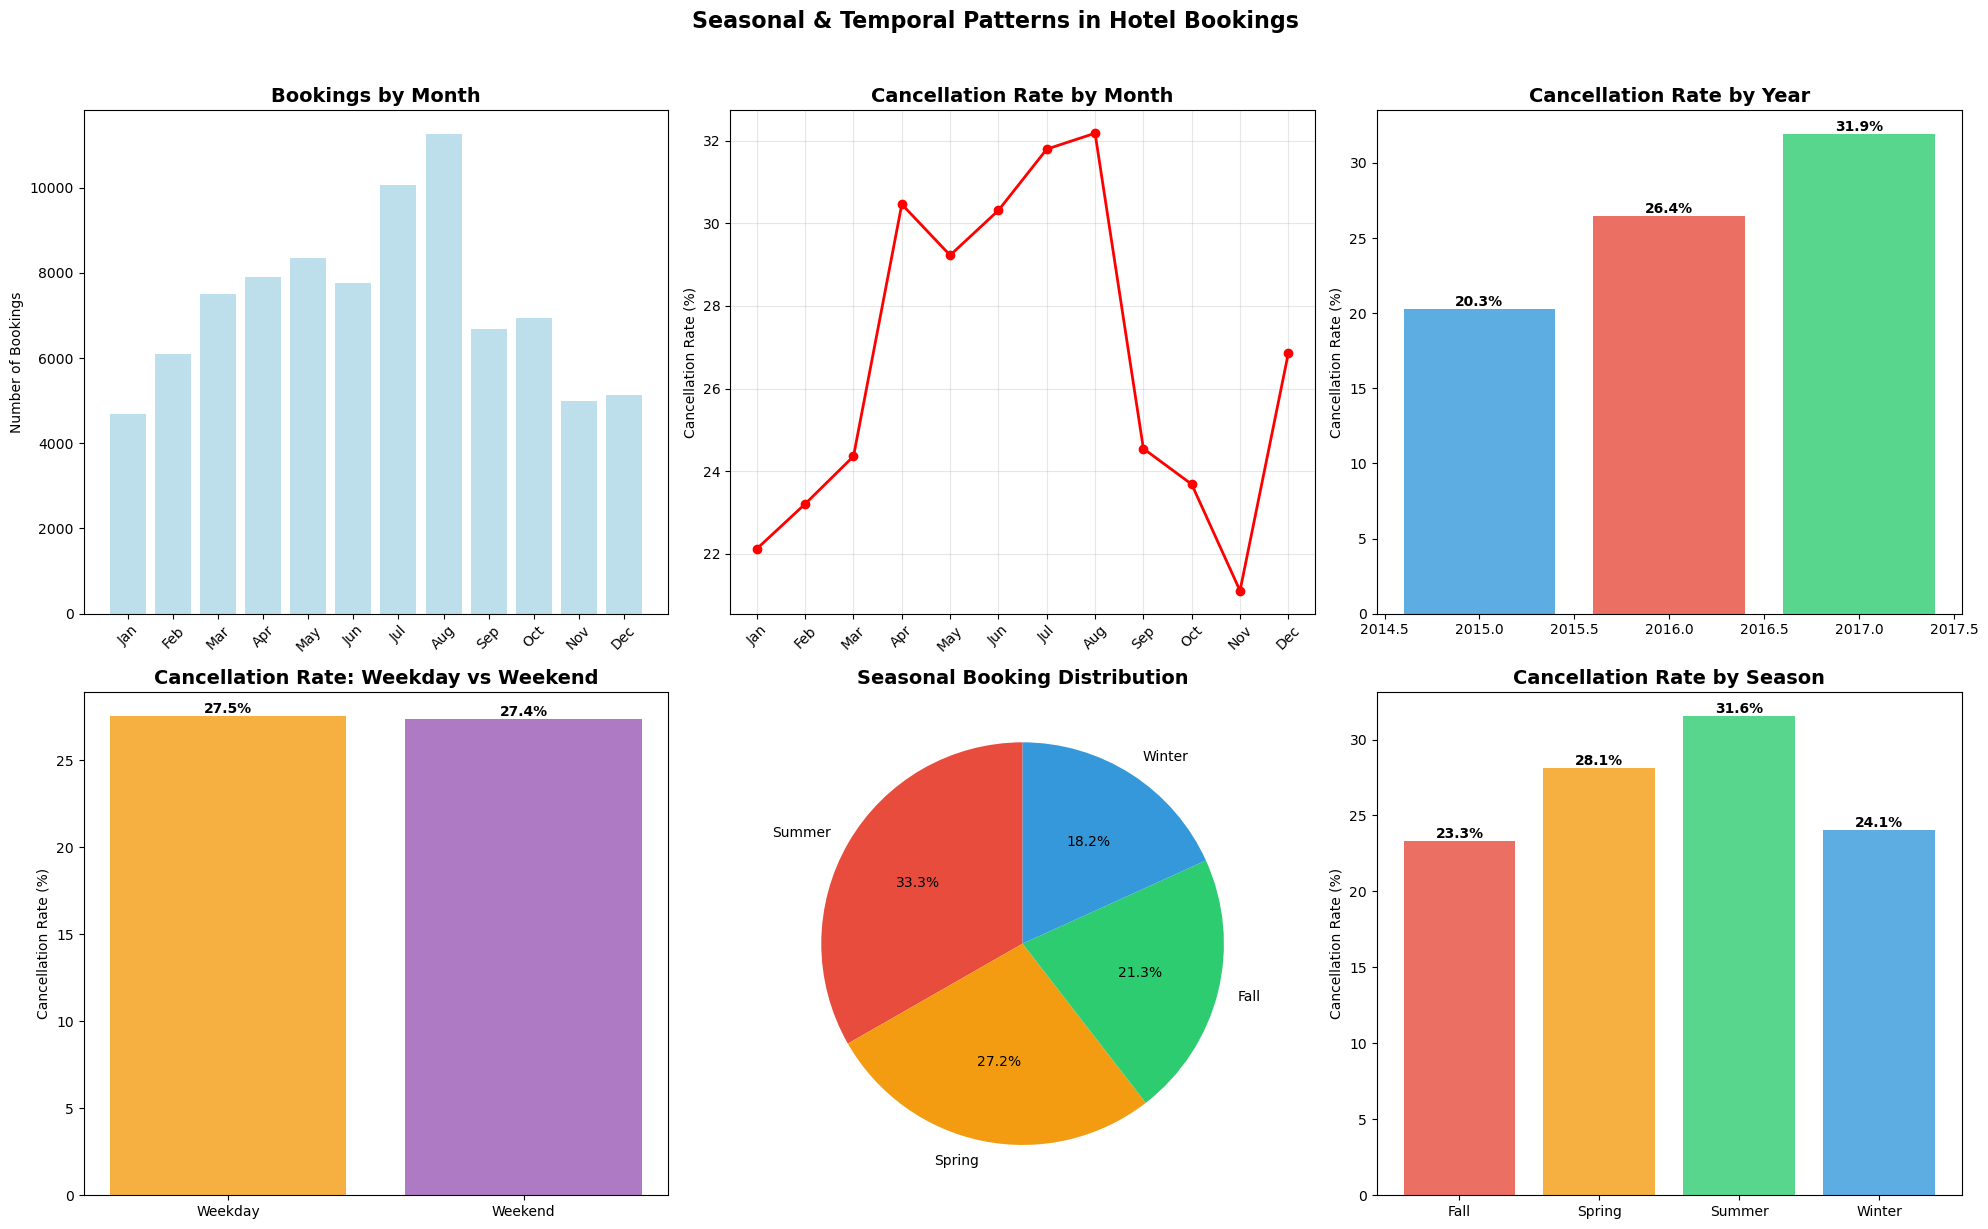

🗓️ SEASONAL & TEMPORAL INSIGHTS:
Monthly Patterns:
   • Peak booking month: August (11,257 bookings)
   • Lowest booking month: January (4,693 bookings)
   • Highest cancellation month: August (32.2%)
   • Lowest cancellation month: November (21.1%)

Seasonal Patterns:
   • Fall: 23.3% cancellation rate (18,619 bookings)
   • Spring: 28.1% cancellation rate (23,776 bookings)
   • Summer: 31.6% cancellation rate (29,079 bookings)
   • Winter: 24.1% cancellation rate (15,922 bookings)

Yearly Trends:
   • 2015: 20.3% cancellation rate (13,313.0 bookings)
   • 2016: 26.4% cancellation rate (42,391.0 bookings)
   • 2017: 31.9% cancellation rate (31,692.0 bookings)


In [21]:
# CELL 7: Seasonal and Temporal Analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Monthly arrival patterns
monthly_bookings = df_clean['arrival_date_month'].value_counts()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_bookings = monthly_bookings.reindex(month_order)

axes[0,0].bar(range(12), monthly_bookings.values, color='lightblue', alpha=0.8)
axes[0,0].set_title('Bookings by Month', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Number of Bookings')
axes[0,0].set_xticks(range(12))
axes[0,0].set_xticklabels([m[:3] for m in month_order], rotation=45)

# Monthly cancellation rates
monthly_cancel = df_clean.groupby('arrival_date_month')['is_canceled'].mean() * 100
monthly_cancel = monthly_cancel.reindex(month_order)

axes[0,1].plot(range(12), monthly_cancel.values, marker='o', color='red', linewidth=2, markersize=6)
axes[0,1].set_title('Cancellation Rate by Month', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Cancellation Rate (%)')
axes[0,1].set_xticks(range(12))
axes[0,1].set_xticklabels([m[:3] for m in month_order], rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Year analysis
if 'arrival_date_year' in df_clean.columns:
    yearly_cancel = df_clean.groupby('arrival_date_year')['is_canceled'].agg(['count', 'mean']).reset_index()
    yearly_cancel['cancel_rate'] = yearly_cancel['mean'] * 100
    
    axes[0,2].bar(yearly_cancel['arrival_date_year'], yearly_cancel['cancel_rate'], 
                  color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8)
    axes[0,2].set_title('Cancellation Rate by Year', fontsize=14, fontweight='bold')
    axes[0,2].set_ylabel('Cancellation Rate (%)')
    for i, v in enumerate(yearly_cancel['cancel_rate']):
        axes[0,2].text(yearly_cancel['arrival_date_year'].iloc[i], v, 
                       f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Weekend vs weekday analysis
df_clean['day_type'] = df_clean['arrival_date_day_of_month'].apply(
    lambda x: 'Weekend' if x % 7 in [0, 6] else 'Weekday'  # Simplified weekday logic
)

day_type_cancel = df_clean.groupby('day_type')['is_canceled'].agg(['count', 'mean']).reset_index()
day_type_cancel['cancel_rate'] = day_type_cancel['mean'] * 100

axes[1,0].bar(day_type_cancel['day_type'], day_type_cancel['cancel_rate'], 
              color=['#f39c12', '#9b59b6'], alpha=0.8)
axes[1,0].set_title('Cancellation Rate: Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Cancellation Rate (%)')
for i, v in enumerate(day_type_cancel['cancel_rate']):
    axes[1,0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Seasonal analysis
def get_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    else:
        return 'Fall'

df_clean['season'] = df_clean['arrival_date_month'].apply(get_season)
season_cancel = df_clean.groupby('season')['is_canceled'].agg(['count', 'mean']).reset_index()
season_cancel['cancel_rate'] = season_cancel['mean'] * 100

# Pie chart for seasonal distribution
season_counts = df_clean['season'].value_counts()
colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']
axes[1,1].pie(season_counts.values, labels=season_counts.index, autopct='%1.1f%%', 
              colors=colors, startangle=90)
axes[1,1].set_title('Seasonal Booking Distribution', fontsize=14, fontweight='bold')

# Seasonal cancellation rates
bars = axes[1,2].bar(season_cancel['season'], season_cancel['cancel_rate'], 
                     color=colors, alpha=0.8)
axes[1,2].set_title('Cancellation Rate by Season', fontsize=14, fontweight='bold')
axes[1,2].set_ylabel('Cancellation Rate (%)')
for i, v in enumerate(season_cancel['cancel_rate']):
    axes[1,2].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Seasonal & Temporal Patterns in Hotel Bookings', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Key insights
print("🗓️ SEASONAL & TEMPORAL INSIGHTS:")
print("Monthly Patterns:")
peak_month = monthly_bookings.idxmax()
low_month = monthly_bookings.idxmin()
print(f"   • Peak booking month: {peak_month} ({monthly_bookings[peak_month]:,} bookings)")
print(f"   • Lowest booking month: {low_month} ({monthly_bookings[low_month]:,} bookings)")

highest_cancel_month = monthly_cancel.idxmax()
lowest_cancel_month = monthly_cancel.idxmin()
print(f"   • Highest cancellation month: {highest_cancel_month} ({monthly_cancel[highest_cancel_month]:.1f}%)")
print(f"   • Lowest cancellation month: {lowest_cancel_month} ({monthly_cancel[lowest_cancel_month]:.1f}%)")

print("\nSeasonal Patterns:")
for idx, row in season_cancel.iterrows():
    season = row['season']
    cancel_rate = row['cancel_rate']
    count = row['count']
    print(f"   • {season}: {cancel_rate:.1f}% cancellation rate ({count:,} bookings)")

if 'arrival_date_year' in df_clean.columns:
    print(f"\nYearly Trends:")
    for idx, row in yearly_cancel.iterrows():
        year = int(row['arrival_date_year'])
        cancel_rate = row['cancel_rate']
        count = row['count']
        print(f"   • {year}: {cancel_rate:.1f}% cancellation rate ({count:,} bookings)")

#### Region Approach (Booking Sukses)

In [22]:
asia = ['AFG','ARE','ARM','AZE','BHR','BGD','BRN','BTN','CHN','CYP','GEO','HKG','IDN','IND','IRN','IRQ','ISR','JOR','JPN','KAZ','KGZ','KWT','LAO','LBN','LKA','MAC','MDV','MMR','MNG','MYS','NPL','OMN','PAK','PHL','QAT','SAU','SGP','SYR','THA','TJK','TUR','TWN','UZB','VNM','YEM']
europe = ['ALB','AND','AUT','BEL','BGR','BIH','BLR','CHE','CYP','CZE','DEU','DNK','ESP','EST','FIN','FRA','GBR','GRC','HRV','HUN','ISL','IRL','ITA','LTU','LUX','LVA','MCO','MKD','MLT','MNE','NLD','NOR','POL','PRT','ROU','RUS','SMR','SRB','SVK','SVN','SWE','UKR']
america = ['ARG','BHS','BLZ','BOL','BRA','CAN','CHL','COL','CRI','CUB','DMA','DOM','ECU','GLP','GRD','GTM','GUY','HTI','HND','JAM','KNA','LCA','MEX','NIC','PAN','PER','PRI','PRY','SLV','SUR','TTO','URY','USA','VEN']
africa = ['AGO','BDI','BEN','BFA','BWA','CAF','CIV','CMR','COD','COG','COM','CPV','DJI','DZA','EGY','ETH','GAB','GHA','GIN','GMB','GNQ','KEN','LBR','LBY','LSO','MAR','MDG','MLI','MOZ','MRT','MUS','MWI','NAM','NER','NGA','REU','RWA','SDN','SEN','SLE','STP','SWZ','TCD','TGO','TUN','TZA','UGA','ZAF','ZMB','ZWE']
australia = ['AUS','NZL','FJI','PNG','WSM','SLB','TON','VUT','NCL']


In [23]:
def map_region(country):
    if country in asia:
        return 'Asia'
    elif country in europe:
        return 'Europe'
    elif country in america:
        return 'America'
    elif country in africa:
        return 'Africa'
    elif country in australia:
        return 'Australia'
    else:
        return 'Other'
    
df_not_cancel.assign(region=df_not_cancel['country'].map(map_region)).groupby('season')['region'].value_counts().unstack(fill_value=0)


region,Africa,America,Asia,Australia,Europe,Other
season,,,,,,
Fall,119,661,360,75,12742,324
Spring,123,881,377,95,15290,329
Summer,159,1001,404,144,17689,507
Winter,162,603,320,32,10741,233


Berdasarkan Data tersebut, maka region eropa memiliki jumlah pengunjung terbanyak terutama pada musim panas atau summer. Hal ini dapat menjadi acuan bagi tim marketing untuk lebih gencar melakukan promosi pada region tersebut

#### Adr to Booking Decision Analysis 

In [24]:
avg_adr_table = (
    df_clean
    .groupby(['season', 'hotel', 'is_canceled'])['adr']
    .mean()
    .unstack(fill_value=0)
    .round(2)
)
avg_adr_table

is_canceled               0       1
season hotel                       
Fall   City Hotel    104.97  112.36
       Resort Hotel   70.16   80.05
Spring City Hotel    109.99  122.17
       Resort Hotel   70.59   81.20
Summer City Hotel    121.01  127.22
       Resort Hotel  153.08  170.03
Winter City Hotel     87.16   93.62
       Resort Hotel   55.31   60.87

Berdasarkan tabel diatas, maka harga bukanlah penyebab utama adanya pembatalan dan terjadinya lonjakan permintaan pada bulan juli dan agustus atau sepanjang musim panas. Hal ini memperkuat alasan bahwa pengunjung atau customer memesan karena musim panas merupakan musim libur secara global, sehingga pemesanan dapat melonjak dengan aktivitas liburan yang tinggi.

#### Season by Family Status

In [25]:
df_not_cancel.groupby(['season','market_segment'])['is_family'].value_counts().unstack(fill_value=0)

is_family                 0     1
season market_segment            
Fall   Aviation          46     0
       Complementary    148    10
       Corporate       1020    21
       Direct          1718   166
       Groups          1362    22
       Offline TA/TO   3053   101
       Online TA       6127   487
Spring Aviation          93     0
       Complementary    139     6
       Corporate       1041    11
       Direct          2137   263
       Groups          1300    18
       Offline TA/TO   2823   118
       Online TA       8370   776
Summer Aviation          37     0
       Complementary    123    20
       Corporate        588     8
       Direct          2650   784
       Groups           424     5
       Offline TA/TO   3439   240
       Online TA       9698  1888
Winter Aviation           6     0
       Complementary    152    16
       Corporate       1008     5
       Direct          2100   249
       Groups           468     8
       Offline TA/TO   1930   122
       Online TA       5386   641

Berdasarkan visualisasi utama pada analisis ini, terlihat bahwa **puncak pemesanan hotel terjadi pada bulan Juli dan Agustus**. Fenomena ini menunjukkan adanya pola **musiman (seasonal pattern)** yang kuat, terutama pada periode **musim panas (Summer)**.  

Kecenderungan ini didukung oleh beberapa faktor, di antaranya:
1. **Efek musiman**, di mana bulan Juli–Agustus merupakan periode liburan utama di banyak negara terutama region eropa.
2. **Harga kamar (ADR) yang lebih tinggi namun tetap diminati**, menandakan tingginya willingness to pay pada periode liburan.
3. **Peningkatan jumlah tamu keluarga dan pasangan**, yang memanfaatkan liburan sekolah untuk bepergian.

Secara keseluruhan, hasil ini menunjukkan bahwa bulan Juli–Agustus merupakan **peak season** dalam industri perhotelan, di mana permintaan tinggi tetap terjadi meskipun harga meningkat. Dengan memahami pola ini, hotel dapat **mengoptimalkan strategi penetapan harga, promosi, dan kapasitas operasional** untuk memaksimalkan pendapatan selama musim liburan.

## **Customer Insight Analysis**

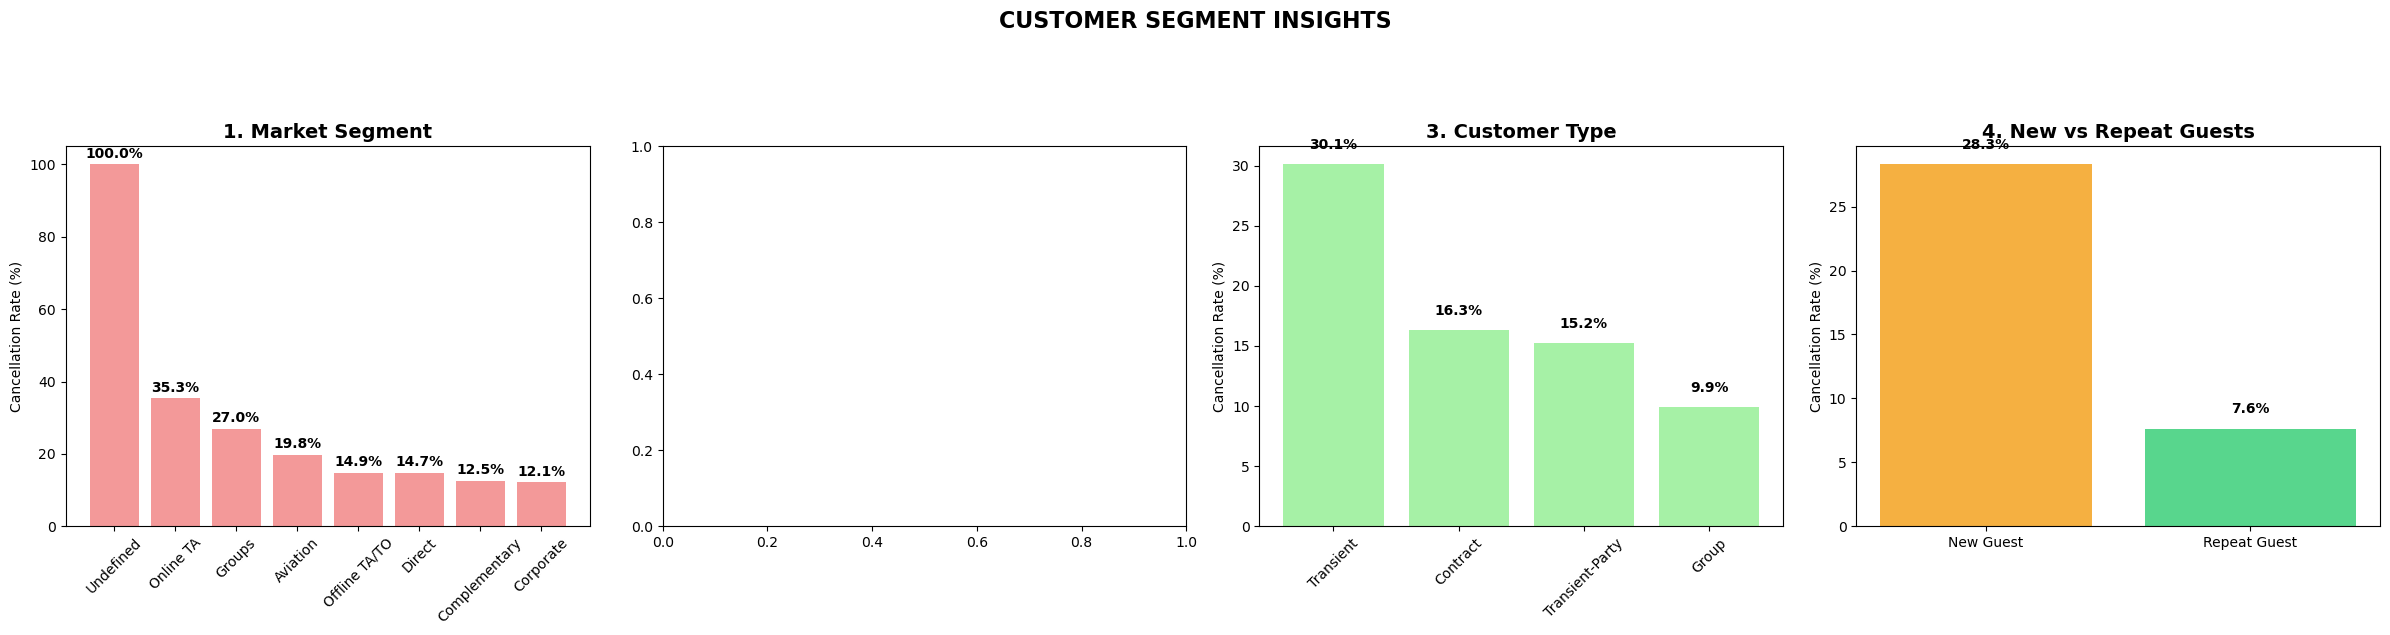

👥 CUSTOMER SEGMENT INSIGHTS:
Market Segment Performance:
   • Segmen Risiko TERENDAH: Corporate (12.1% pembatalan)
   • Segmen Risiko TERTINGGI: Undefined (100.0% pembatalan)

Customer Type Performance:
   • Transient: 30.1% tingkat pembatalan
   • Contract: 16.3% tingkat pembatalan

Perbandingan Tamu:
   • Tamu Baru (New Guest): 28.3% tingkat pembatalan
   • Tamu Berulang (Repeat Guest): 7.6% tingkat pembatalan


In [26]:
# CUSTOMER SEGMENT INSIGHTS

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
fig.subplots_adjust(wspace=0.3)

# 1. Market segment analysis
market_segment_cancel = df_clean.groupby('market_segment')['is_canceled'].agg(['count', 'mean']).reset_index()
market_segment_cancel['cancel_rate'] = market_segment_cancel['mean'] * 100
market_segment_cancel = market_segment_cancel.sort_values('cancel_rate', ascending=False)

bars = axes[0].bar(market_segment_cancel['market_segment'], market_segment_cancel['cancel_rate'], 
                 color='lightcoral', alpha=0.8)
axes[0].set_title('1. Market Segment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cancellation Rate (%)')
axes[0].tick_params(axis='x', rotation=45)
for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontweight='bold')


# 2. Distribution Channel analysis
if 'distribution_channel' in df_clean.columns:
    channel_cancel = df_clean.groupby('distribution_channel')['is_canceled'].agg(['count', 'mean']).reset_index()
    channel_cancel['cancel_rate'] = channel_cancel['mean'] * 100
    channel_cancel = channel_cancel.sort_values('cancel_rate', ascending=False)
    
    bars = axes[1].bar(range(len(channel_cancel)), channel_cancel['cancel_rate'], 
                      color='lightblue', alpha=0.8)
    axes[1].set_title('2. Distribution Channel', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Cancellation Rate (%)')
    axes[1].set_xticks(range(len(channel_cancel)))
    axes[1].set_xticklabels(channel_cancel['distribution_channel'], rotation=45, ha='right')
    for bar in bars:
        yval = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Customer Type analysis
if 'customer_type' in df_clean.columns:
    customer_cancel = df_clean.groupby('customer_type')['is_canceled'].agg(['count', 'mean']).reset_index()
    customer_cancel['cancel_rate'] = customer_cancel['mean'] * 100
    customer_cancel = customer_cancel.sort_values('cancel_rate', ascending=False)
    
    bars = axes[2].bar(customer_cancel['customer_type'], customer_cancel['cancel_rate'], 
                      color='lightgreen', alpha=0.8)
    axes[2].set_title('3. Customer Type', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Cancellation Rate (%)')
    axes[2].tick_params(axis='x', rotation=45)
    for bar in bars:
        yval = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Repeat Guest analysis
if 'is_repeated_guest' in df_clean.columns:
    repeat_cancel = df_clean.groupby('is_repeated_guest')['is_canceled'].agg(['count', 'mean']).reset_index()
    repeat_cancel['cancel_rate'] = repeat_cancel['mean'] * 100
    repeat_cancel['guest_type'] = repeat_cancel['is_repeated_guest'].map({0: 'New Guest', 1: 'Repeat Guest'})
    
    bars = axes[3].bar(repeat_cancel['guest_type'], repeat_cancel['cancel_rate'], 
                      color=['#f39c12', '#2ecc71'], alpha=0.8)
    axes[3].set_title('4. New vs Repeat Guests', fontsize=14, fontweight='bold')
    axes[3].set_ylabel('Cancellation Rate (%)')
    for bar in bars:
        yval = bar.get_height()
        axes[3].text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontweight='bold')


plt.suptitle('CUSTOMER SEGMENT INSIGHTS', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Key insights ---
print("👥 CUSTOMER SEGMENT INSIGHTS:")

# Market Segment Performance
market_segment_cancel = market_segment_cancel.sort_values('cancel_rate', ascending=True)
best_segment = market_segment_cancel.loc[market_segment_cancel['cancel_rate'].idxmin()]
worst_segment = market_segment_cancel.loc[market_segment_cancel['cancel_rate'].idxmax()]
print("Market Segment Performance:")
print(f"   • Segmen Risiko TERENDAH: {best_segment['market_segment']} ({best_segment['cancel_rate']:.1f}% pembatalan)")
print(f"   • Segmen Risiko TERTINGGI: {worst_segment['market_segment']} ({worst_segment['cancel_rate']:.1f}% pembatalan)")

# Distribution Channel Performance
if 'distribution_channel' in df_clean.columns:
    channel_cancel = channel_cancel.sort_values('cancel_rate', ascending=False)
    print(f"\nDistribution Channel Performance:")
    for idx, row in channel_cancel.head(2).iterrows():
        channel = row['distribution_channel']
        cancel_rate = row['cancel_rate']
        print(f"   • {channel}: {cancel_rate:.1f}% tingkat pembatalan")

# Customer Type Performance
if 'customer_type' in df_clean.columns:
    customer_cancel = customer_cancel.sort_values('cancel_rate', ascending=False)
    print(f"\nCustomer Type Performance:")
    for idx, row in customer_cancel.head(2).iterrows():
        cust_type = row['customer_type']
        cancel_rate = row['cancel_rate']
        print(f"   • {cust_type}: {cancel_rate:.1f}% tingkat pembatalan")


# Repeat Guest Performance
if 'is_repeated_guest' in df_clean.columns:
    new_guest_cancel = repeat_cancel[repeat_cancel['is_repeated_guest'] == 0]['cancel_rate'].iloc[0]
    repeat_guest_cancel = repeat_cancel[repeat_cancel['is_repeated_guest'] == 1]['cancel_rate'].iloc[0]
    print(f"\nPerbandingan Tamu:")
    print(f"   • Tamu Baru (New Guest): {new_guest_cancel:.1f}% tingkat pembatalan")
    print(f"   • Tamu Berulang (Repeat Guest): {repeat_guest_cancel:.1f}% tingkat pembatalan")

#### Market Segment & Distribution Channel

Terlihat bahwa pada market segment **Online TA** memiliki tingkat cancel rate tertinggi, maka perlu ditelusuri mengapa hal itu bisa terjadi. Dalam hal ini, maka jumlah atau proporsi pembagian `market segment` akan dicek terlebih dahulu untuk memperkuat alasan yang akan dibangun

In [27]:
market_segment_df = pd.DataFrame({
    'Jumlah': df_clean['market_segment'].value_counts(),
    'Proporsi (%)': df_clean['market_segment'].value_counts(normalize=True) * 100,
    'Cancelation_rate': df_clean.groupby('market_segment')['is_canceled'].mean() * 100,
    'Total Cancelations': df_clean.groupby('market_segment')['is_canceled'].sum()
}).reset_index()

market_segment_df.rename(columns={'index': 'Market Segment'}, inplace=True)

display(market_segment_df.sort_values(by='Cancelation_rate', ascending=False))

,market_segment,Jumlah,Proporsi (%),Cancelation_rate,Total Cancelations
7,Undefined,2,0.002288,100.000000,2
6,Online TA,51618,59.062200,35.346197,18245
4,Groups,4942,5.654721,27.013355,1335
0,Aviation,227,0.259737,19.823789,45
5,Offline TA/TO,13889,15.892032,14.853481,2063
3,Direct,11804,13.506339,14.715351,1737
1,Complementary,702,0.803240,12.535613,88
2,Corporate,4212,4.819443,12.108262,510


Berdasarkan jumlahnya, nilai cancelation rate yang tinggi dapat didadasari oleh jauh lebih banyaknya data yang berada pada `market segment` dengan jenis Online TA yaitu dengan proporsi data sebesar 59%. Alasan lainnya adalah pembatalan pesanan yang dipesan oleh `market segment` Online TA biasanya lebih mudah melakukan akses pembatalan oleh pengguna beberapa hari sebelum hari check-in dibandingkan dengan jenis lainnya. Contohnya ada pada aplikasi seperti Tiket.com ataupun Traveloka yang memiliki opsi pembatalan dengan refund 100% sehingga pengguna lebih mudah mengatur pembatalan

In [29]:
# First, check if 'distribution_channel' column exists
if 'distribution_channel' in df_clean.columns:
    distribution_channel_df = pd.DataFrame({
        'Jumlah': df_clean['distribution_channel'].value_counts(),
        'Proporsi (%)': df_clean['distribution_channel'].value_counts(normalize=True) * 100,
        'Cancelation_rate': df_clean.groupby('distribution_channel')['is_canceled'].mean() * 100,
        'Total Cancelations': df_clean.groupby('distribution_channel')['is_canceled'].sum()
    }).reset_index()

    distribution_channel_df.rename(columns={'index': 'Distribution Channel'}, inplace=True)

    display(distribution_channel_df.sort_values(by='Cancelation_rate', ascending=False))
else:
    print("⚠️ Column 'distribution_channel' not found in the dataset.")
    print(f"Available columns: {df_clean.columns.tolist()}")

⚠️ Column 'distribution_channel' not found in the dataset.
Available columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'total_people', 'weekend_ratio', 'booking_complexity', 'customer_reliability', 'lead_time_category', 'season', 'is_peak_season', 'is_family', 'day_type']


Bagian Distribution Channel juga menunjukkan bahwa TA/TO memiliki cancelation rate yang tinggi, Hal ini tentunya karena TA/TO berkaitan secara langsung dengan market segment Online TA dan Offline TA/TO. Sedangakan untuk Undefined sendiri bisa dikatakan sebagai sebuah outlier dan dapat dihapus karena jumlahnya hanya 1 sehingga besar kemungkinan bahwa itu adalah data yang boleh untuk tidak digunakan.

#### Customer Type

Untuk jenis customer, jenis transient memiliki cancelation rate tertinggi. Hal ini bisa berkaitan dengan penyebab seblumnya dimana pengguna atau customer dengan tipe transient kebanyakan berasal dari market segment dan distribution channel yang berkaitan dengan TA/TO

In [30]:
df_clean.groupby('customer_type')['market_segment'].value_counts().unstack().fillna(0).sort_values(by='Online TA', ascending=False)

market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA,Undefined
customer_type,,,,,,,,
Transient,209.0,665.0,3134.0,10803.0,918.0,8904.0,47353.0,0.0
Transient-Party,16.0,29.0,1032.0,857.0,3948.0,3079.0,2764.0,2.0
Contract,0.0,2.0,18.0,14.0,63.0,1714.0,1328.0,0.0
Group,2.0,6.0,28.0,130.0,13.0,192.0,173.0,0.0


Terbukti bahwa sebagian besar customer type transient berasal dari market segment yang berhubungan dengan TA/TO sehingga kenaikan cancelation rate pada `market segment` akan berpengaruh kepada `customer type`, begitupun sebaliknya.

#### Repeated Guest

Repeated guest menandakan apakah pelanggan atau customer meupakan orang yang pernah memesan kemudian memesan kembali ke Hotel Alpha. berdasarkan hasil visualisasi, terlihat bahwa cancelation rate yang ditimbulkan akibat orang yang pernah memesan jauh lebih kecil dibandingnkan dengan customer baru. Namun potensi ini perlu dicari lebih lanjut apakah hal ini berkaitan dengan distribusi jumlahnya yang tidak merata sehingga hasilnya jauh lebih sedikit atau karena ada hal lainnya

In [31]:
repeated_df = pd.DataFrame({
    'Jumlah': df_clean['is_repeated_guest'].value_counts(),
    'Proporsi (%)': df_clean['is_repeated_guest'].value_counts(normalize=True) * 100,
    'Cancelation_rate': df_clean.groupby('is_repeated_guest')['is_canceled'].mean() * 100,
    'Total Cancelations': df_clean.groupby('is_repeated_guest')['is_canceled'].sum()
}).reset_index()

repeated_df.rename(columns={'index': 'Repeated Guest'}, inplace=True)

display(repeated_df.sort_values(by='Cancelation_rate', ascending=False))

,is_repeated_guest,Jumlah,Proporsi (%),Cancelation_rate,Total Cancelations
0,0,83981,96.092499,28.296877,23764
1,1,3415,3.907501,7.642753,261


Terlihat jelas bahwa proporsinya sangat tidak seimbang sehingga angka 7% pada cancelation rate tidak langsung merepresentasikan bahwa dengan repeated guest akan lebih menguntungkan dengan alasan lebih loyal. Bukti yang tercantum adalah bagaimana pelanggan baru menyumbang proporsi data sebeasr 96% sehingga potensi yang sangat tinggi muncul dengan hasil yang dapat lebih menguntungkan dengan menggaet atau menarik pelanggan pelanggan baru dengan harapannya dikemudian hari akan menjadi customer yang akan memesan kembali ke Hotel Alpha karena adanya potensi yang cukup baik yang ditunjukkan oleh jenis pelanggan yang memesan berulang dengan cancelation rate yang rendah.

## **Booking Behaviour and Revenue Analysis**

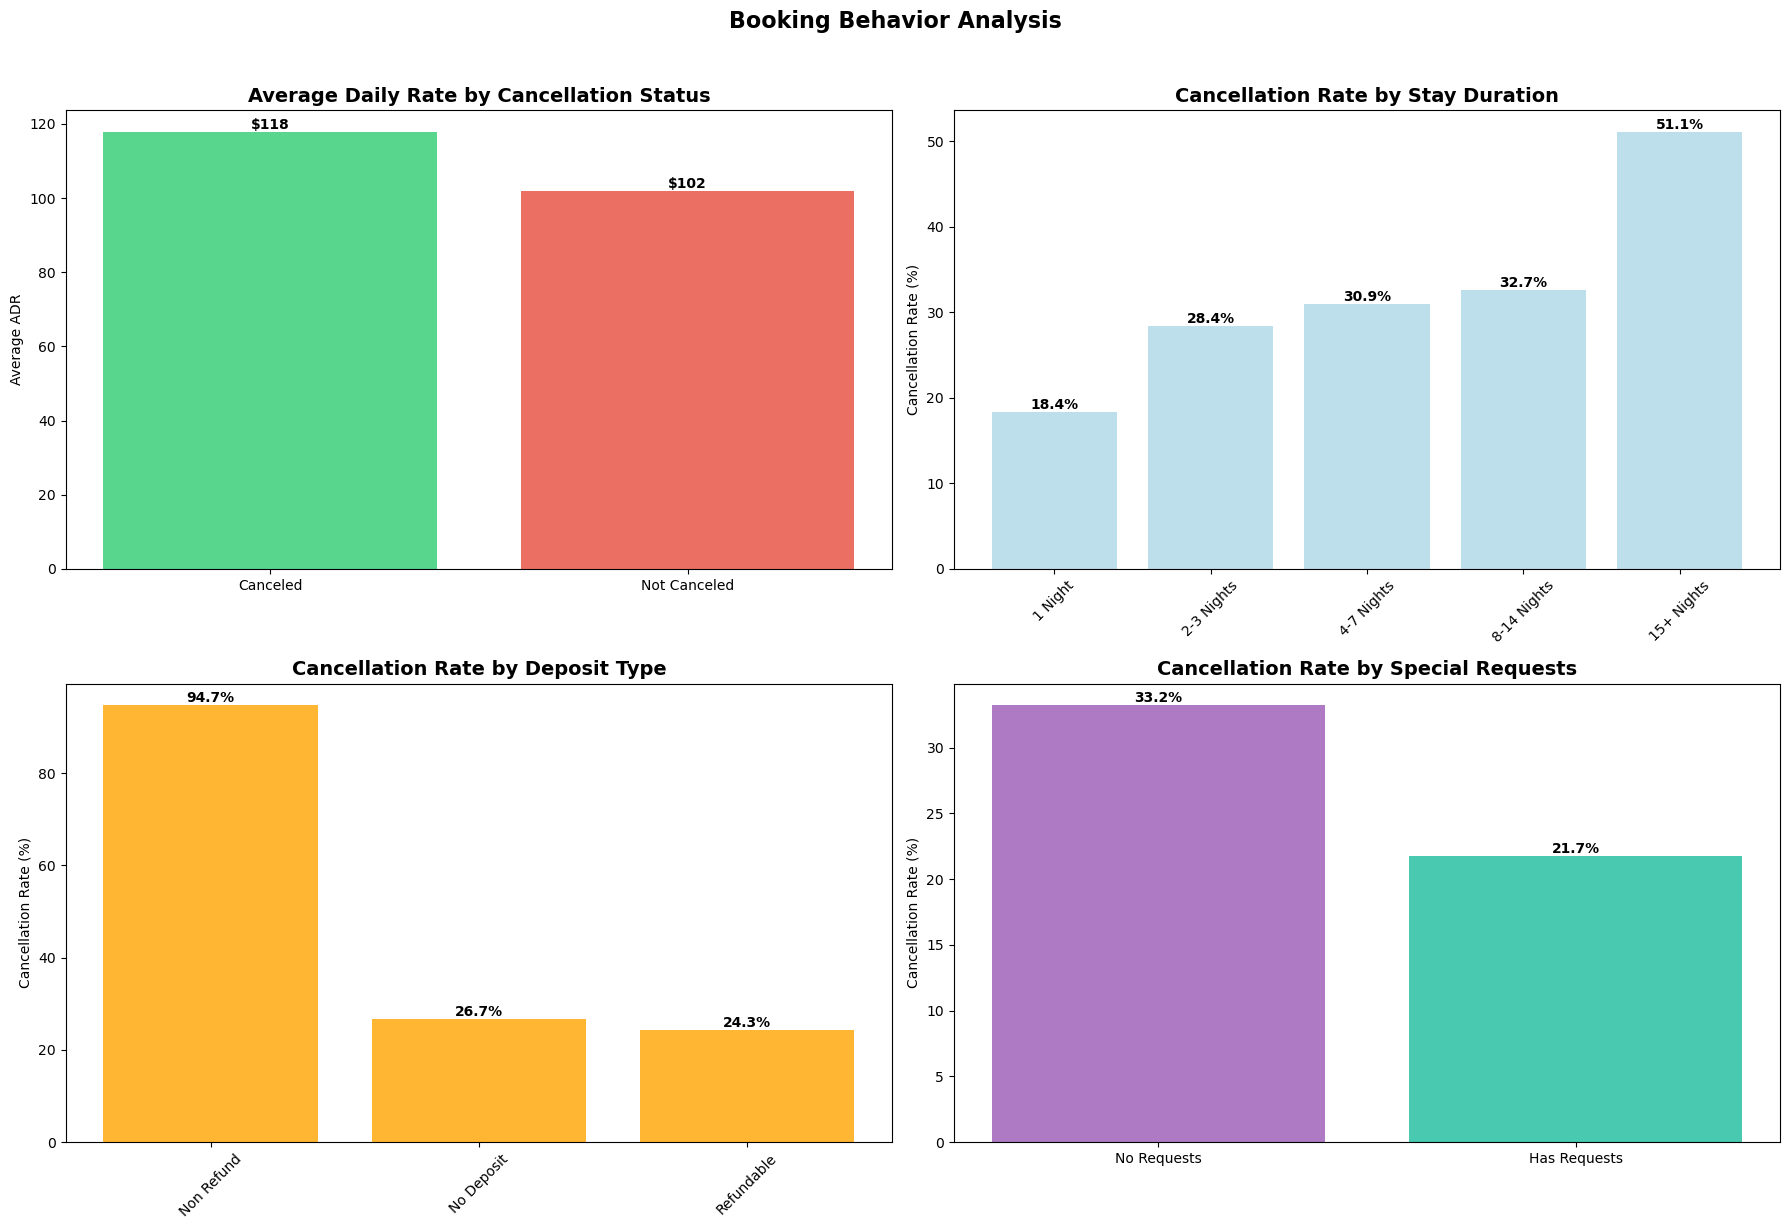

💰 BOOKING BEHAVIOR INSIGHTS:
ADR Analysis:
   • Not canceled bookings: $102 average ADR
   • Canceled bookings: $118 average ADR
   • ⚠️  Higher ADR bookings are more likely to be canceled!

Stay Duration Impact:
   • 1 Night: 18.4% cancellation rate (17,184 bookings)
   • 2-3 Nights: 28.4% cancellation rate (33,584 bookings)
   • 4-7 Nights: 30.9% cancellation rate (31,115 bookings)
   • 8-14 Nights: 32.7% cancellation rate (4,488 bookings)
   • 15+ Nights: 51.1% cancellation rate (374 bookings)

   💡 Deposit Impact: No deposit cancellation rate: 26.7%

   🎯 Special Request Impact:
      • No requests: 33.2% cancellation rate
      • Has requests: 21.7% cancellation rate


In [32]:
# CELL 9: Booking Behavior Analysis (Clean Version)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# ADR (Average Daily Rate) analysis
adr_cancel = df_clean.groupby('is_canceled')['adr'].agg(['mean', 'median', 'std']).reset_index()
adr_cancel['cancel_status'] = adr_cancel['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})
adr_cancel = adr_cancel.sort_values('mean', ascending=False)

axes[0,0].bar(adr_cancel['cancel_status'], adr_cancel['mean'], 
              color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[0,0].set_title('Average Daily Rate by Cancellation Status', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Average ADR')
for i, v in enumerate(adr_cancel['mean']):
    axes[0,0].text(i, v, f'${v:.0f}', ha='center', va='bottom', fontweight='bold')

# Stay duration analysis
df_clean['total_nights'] = df_clean['stays_in_weekend_nights'] + df_clean['stays_in_week_nights']
df_clean['stay_category'] = pd.cut(
    df_clean['total_nights'], 
    bins=[0, 1, 3, 7, 14, float('inf')], 
    labels=['1 Night', '2-3 Nights', '4-7 Nights', '8-14 Nights', '15+ Nights']
)

stay_cancel = df_clean.groupby('stay_category')['is_canceled'].agg(['count', 'mean']).reset_index()
stay_cancel['cancel_rate'] = stay_cancel['mean'] * 100

axes[0,1].bar(stay_cancel['stay_category'], stay_cancel['cancel_rate'], 
              color='lightblue', alpha=0.8)
axes[0,1].set_title('Cancellation Rate by Stay Duration', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Cancellation Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(stay_cancel['cancel_rate']):
    axes[0,1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Deposit type analysis
if 'deposit_type' in df_clean.columns:
    deposit_cancel = df_clean.groupby('deposit_type')['is_canceled'].agg(['count', 'mean']).reset_index()
    deposit_cancel['cancel_rate'] = deposit_cancel['mean'] * 100
    deposit_cancel = deposit_cancel.sort_values('cancel_rate', ascending=False)
    axes[1,0].bar(deposit_cancel['deposit_type'], deposit_cancel['cancel_rate'], 
                  color='orange', alpha=0.8)
    axes[1,0].set_title('Cancellation Rate by Deposit Type', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Cancellation Rate (%)')
    axes[1,0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(deposit_cancel['cancel_rate']):
        axes[1,0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Special requests analysis
if 'total_of_special_requests' in df_clean.columns:
    df_clean['has_special_requests'] = df_clean['total_of_special_requests'] > 0
    requests_cancel = df_clean.groupby('has_special_requests')['is_canceled'].agg(['count', 'mean']).reset_index()
    requests_cancel['cancel_rate'] = requests_cancel['mean'] * 100
    requests_cancel['request_type'] = requests_cancel['has_special_requests'].map({False: 'No Requests', True: 'Has Requests'})
    requests_cancel = requests_cancel.sort_values('cancel_rate', ascending=False)
    
    axes[1,1].bar(requests_cancel['request_type'], requests_cancel['cancel_rate'], 
                  color=['#9b59b6', '#1abc9c'], alpha=0.8)
    axes[1,1].set_title('Cancellation Rate by Special Requests', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Cancellation Rate (%)')
    for i, v in enumerate(requests_cancel['cancel_rate']):
        axes[1,1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Booking Behavior Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Key insights
print("💰 BOOKING BEHAVIOR INSIGHTS:")
print("ADR Analysis:")
not_canceled_adr = adr_cancel[adr_cancel['is_canceled'] == 0]['mean'].iloc[0]
canceled_adr = adr_cancel[adr_cancel['is_canceled'] == 1]['mean'].iloc[0]
print(f"   • Not canceled bookings: ${not_canceled_adr:.0f} average ADR")
print(f"   • Canceled bookings: ${canceled_adr:.0f} average ADR")
if canceled_adr > not_canceled_adr:
    print("   • ⚠️  Higher ADR bookings are more likely to be canceled!")
else:
    print("   • ✅ Lower ADR bookings are more likely to be canceled")

print(f"\nStay Duration Impact:")
for idx, row in stay_cancel.iterrows():
    print(f"   • {row['stay_category']}: {row['cancel_rate']:.1f}% cancellation rate ({row['count']:,} bookings)")

if 'deposit_type' in df_clean.columns:
    no_deposit_rate = deposit_cancel[deposit_cancel['deposit_type'] == 'No Deposit']['cancel_rate'].iloc[0] if 'No Deposit' in deposit_cancel['deposit_type'].values else 0
    print(f"\n   💡 Deposit Impact: No deposit cancellation rate: {no_deposit_rate:.1f}%")

if 'total_of_special_requests' in df_clean.columns:
    no_request_rate = requests_cancel[requests_cancel['has_special_requests'] == False]['cancel_rate'].iloc[0]
    has_request_rate = requests_cancel[requests_cancel['has_special_requests'] == True]['cancel_rate'].iloc[0]
    print(f"\n   🎯 Special Request Impact:")
    print(f"      • No requests: {no_request_rate:.1f}% cancellation rate")
    print(f"      • Has requests: {has_request_rate:.1f}% cancellation rate")


In [33]:
df_cancel= df_clean[df_clean['is_canceled']==1]
df_not_cancel = df_clean[df_clean['is_canceled']==0]

#### ADR & Nights Durations

Berdasarkan visualisasi, maka cancel memiliki lebih banyak ADR atau pendapatan rata rata per booking yang berasal dari cancel nilainya lebih tinggi dibandingkan dengan booking yang jadi. Hal ini perlu diselidiki lebih lanjut mengingat jumlah pembatalan atau cancel lebih kecil dibandingkan dengan yang tidak cancel. Maka untuk melakukan pemeriksaan awal kita akan melakukan cek ulang distribusi cancel dan non cancel

In [34]:
book_behav = pd.DataFrame({
    'Jumlah': df_clean['stay_category'].value_counts(),
    'Proporsi (%)': df_clean['stay_category'].value_counts(normalize=True) * 100,
    'Cancelation_rate': df_clean.groupby('stay_category')['is_canceled'].mean() * 100,
    'Total Cancelations': df_clean.groupby('stay_category')['is_canceled'].sum(),
    'Adr Mean Cancel': df_cancel.groupby('stay_category')['adr'].mean(),
    'Adr Mean Not Cancel': df_not_cancel.groupby('stay_category')['adr'].mean()
}).reset_index()

book_behav.rename(columns={'index': 'Stay Category'}, inplace=True)
display(book_behav.sort_values(by='Proporsi (%)', ascending=False))

,stay_category,Jumlah,Proporsi (%),Cancelation_rate,Total Cancelations,Adr Mean Cancel,Adr Mean Not Cancel
1,2-3 Nights,33584,38.715776,28.445093,9553,116.410887,105.661010
2,4-7 Nights,31115,35.869503,30.933633,9625,121.625779,106.719389
0,1 Night,17184,19.809787,18.395019,3161,109.407789,93.385149
3,8-14 Nights,4488,5.173785,32.664884,1466,125.443656,102.138713
4,15+ Nights,374,0.431149,51.069519,191,89.130890,72.260874


Terlihat bahwa pada data yang termasuk cancel, jumlah atau nilai ADR pembatalan memang jauh lebih tinggi dibandingkan dengan yang tidak dibatalkan yaitu pada kategori 8-14 nights dan 4-7 nights, kemudian pembatalan terkecil secara quantity jatih pada 15+ nights dengan 190 pembatalan namun dengan harga pembatalan yang lebih tinggi. Berdasarkan data ini, maka terlihat juga bahwa booking yang di cancel nilai ADR nya selalu lebih tinggi sehingga mengindikasikan bahwa pelanggan menyadari adanya diskon sehingga kemudian membatalkan harga pesanan yang lebih mahal

In [35]:
df_clean['deposit_type'].value_counts()

deposit_type
No Deposit    86251
Non Refund     1038
Refundable      107
Name: count, dtype: int64

Pembahasan ADR juga diperkuat dengan deposit type dengan tipe No deposit jauh dominan secara proporsi data dibandingkan denghan tipe lainnya. Sehingga pelanggan lebih berani untuk memilih pembatalan yang mengakibatkan secara statistik harga pembatalan lebih tinggi dibandingkan dengan yang tidak dibatalkan

In [36]:
df_behav_special_requests = pd.DataFrame({
    'Jumlah': df_clean['has_special_requests'].value_counts(),
    'Proporsi (%)': df_clean['has_special_requests'].value_counts(normalize=True) * 100,
    'Cancelation_rate': df_clean.groupby('has_special_requests')['is_canceled'].mean() * 100,
    'Total Cancelations': df_clean.groupby('has_special_requests')['is_canceled'].sum(),
    'adr_mean_cancel': df_cancel.groupby('has_special_requests')['adr'].mean(),
    'adr_mean_not_cancel': df_not_cancel.groupby('has_special_requests')['adr'].mean()
}).reset_index()
df_behav_special_requests.rename(columns={'index': 'Has Special Requests'}, inplace=True)
display(df_behav_special_requests.sort_values(by='Proporsi (%)', ascending=False))

,has_special_requests,Jumlah,Proporsi (%),Cancelation_rate,Total Cancelations,adr_mean_cancel,adr_mean_not_cancel
0,False,43894,50.224267,33.202716,14574,116.354767,91.370018
1,True,43502,49.775733,21.725438,9451,119.958668,111.156715


Special request juga berkaitan dengan pembatalan ini dengan indikasi yang sama yaitu adanya diskon. Hal ini terlihat dengan customer yang memiliki special request memiliki adr lebih tinggi dibandingkan dengan yang tidak.

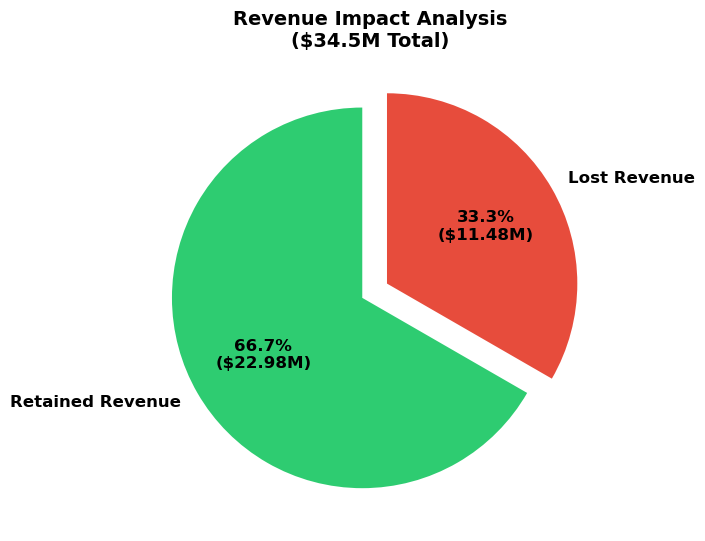

💵 REVENUE IMPACT INSIGHTS:
   • Total potential revenue: $34.46M
   • Revenue lost to cancellations: $11.48M
   • Revenue loss percentage: 33.3%


In [37]:
# CELL 10: Revenue Impact Analysis
df_clean['potential_revenue'] = df_clean['adr'] * df_clean['total_nights']
canceled_revenue = df_clean[df_clean['is_canceled'] == 1]['potential_revenue'].sum()
total_potential_revenue = df_clean['potential_revenue'].sum()
revenue_loss_pct = (canceled_revenue / total_potential_revenue) * 100

# Custom label function
def autopct_with_value(pct, allvals):
    total = sum(allvals)
    val = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n(${val/1_000_000:.2f}M)"

fig, ax = plt.subplots(figsize=(7, 7))
revenue_data = ['Retained Revenue', 'Lost Revenue']
revenue_values = [total_potential_revenue - canceled_revenue, canceled_revenue]
colors = ['#2ecc71', '#e74c3c']

wedges, texts, autotexts = ax.pie(
    revenue_values,
    labels=revenue_data,
    autopct=lambda pct: autopct_with_value(pct, revenue_values),
    colors=colors,
    startangle=90,
    explode=(0.05, 0.1),
    textprops={'fontsize': 12, 'weight': 'bold'}
)

# Judul
ax.set_title(
    f'Revenue Impact Analysis\n(${total_potential_revenue/1_000_000:.1f}M Total)',
    fontsize=14, fontweight='bold'
)

plt.tight_layout()
plt.show()

# --- Text insights ---
print("💵 REVENUE IMPACT INSIGHTS:")
print(f"   • Total potential revenue: ${total_potential_revenue/1_000_000:.2f}M")
print(f"   • Revenue lost to cancellations: ${canceled_revenue/1_000_000:.2f}M")
print(f"   • Revenue loss percentage: {revenue_loss_pct:.1f}%")


Dengan demikian telihat bahwa revenue yang berasal dari pelangggan yang tidak membatalkan lebih tinggi 2 kali lipat dibandingkan dengan potensi yang bisa didapatkan dari orang yang melakukan cancel. Namun hal ini seharusnya memang wajar mengingat proporsi data antara yang melakukan cancel dengan tidak cancel cukup jauh secara kuantitas

## **Revenue Analysis**

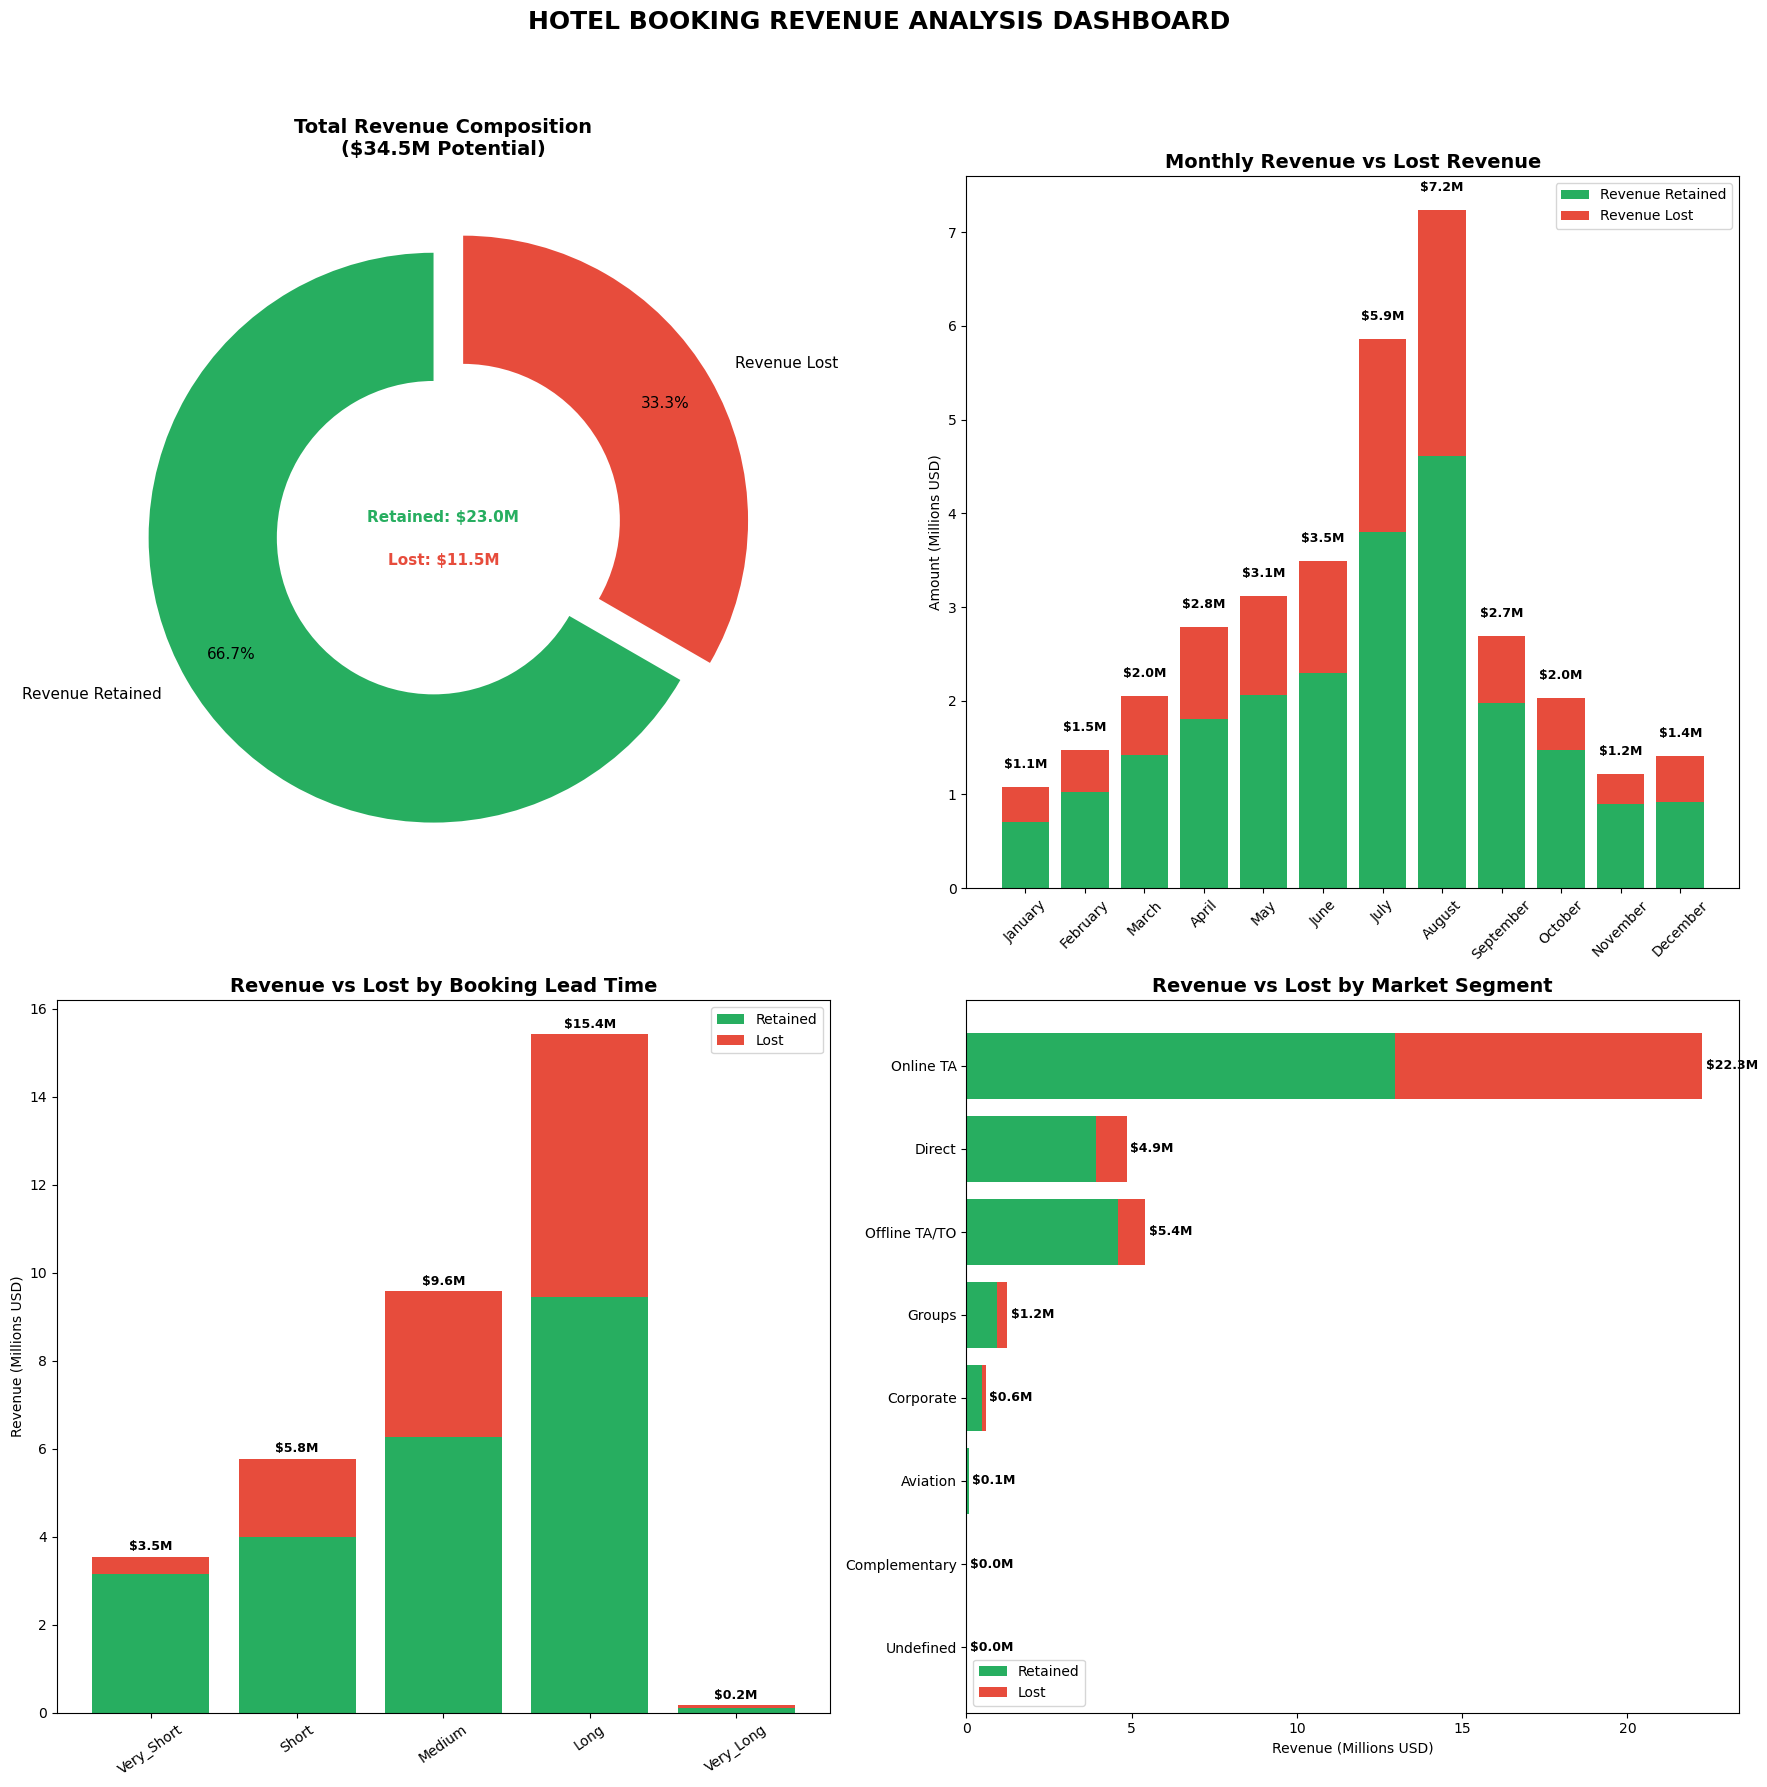

In [38]:
# CELL 12: REVENUE ANALYSIS DASHBOARD (STACKED VERSION)
import matplotlib.pyplot as plt
import pandas as pd

# --- Setup ---
fig, axes = plt.subplots(2, 2, figsize=(18, 18))
fig.subplots_adjust(hspace=0.35, wspace=0.25)

# --- Revenue Metrics ---
df_clean['potential_revenue'] = df_clean['adr'] * df_clean['total_nights']
canceled_bookings = df_clean[df_clean['is_canceled'] == 1]
successful_bookings = df_clean[df_clean['is_canceled'] == 0]

total_potential_revenue = df_clean['potential_revenue'].sum()
lost_revenue = canceled_bookings['potential_revenue'].sum()
retained_revenue = successful_bookings['potential_revenue'].sum()
revenue_loss_percentage = (lost_revenue / total_potential_revenue) * 100

# --- 1. Overall Revenue Composition (Donut Chart) ---
revenue_labels = ['Revenue Retained', 'Revenue Lost']
revenue_values = [retained_revenue, lost_revenue]
colors = ['#27ae60', '#e74c3c']
explode = (0.04, 0.08)

wedges, texts, autotexts = axes[0,0].pie(
    revenue_values, labels=revenue_labels, autopct='%1.1f%%', startangle=90,
    colors=colors, explode=explode, pctdistance=0.82, wedgeprops=dict(width=0.45)
)
for text in texts + autotexts:
    text.set_fontsize(11)

axes[0,0].set_title(
    f'Total Revenue Composition\n(${total_potential_revenue/1e6:.1f}M Potential)',
    fontsize=14, fontweight='bold', pad=15
)

# Tambahkan lingkaran putih di tengah (donut)
axes[0,0].add_artist(plt.Circle((0,0), 0.35, color='white'))

# Tambahkan teks untuk retained dan lost di tengah donat
axes[0,0].text(
    0, 0.05, f"Retained: ${retained_revenue/1e6:.1f}M",
    ha='center', va='center', fontsize=11, color='#27ae60', fontweight='bold'
)
axes[0,0].text(
    0, -0.10, f"Lost: ${lost_revenue/1e6:.1f}M",
    ha='center', va='center', fontsize=11, color='#e74c3c', fontweight='bold'
)

# --- 2. Monthly Revenue vs Lost Revenue (Stacked Bar) ---
monthly_revenue = (
    successful_bookings.groupby('arrival_date_month')['potential_revenue'].sum()
)
monthly_loss = (
    canceled_bookings.groupby('arrival_date_month')['potential_revenue'].sum()
)

month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]

monthly_data = pd.DataFrame({
    'Revenue Retained': monthly_revenue,
    'Revenue Lost': monthly_loss
}).reindex(month_order).fillna(0) / 1e6  # juta USD

axes[0,1].bar(
    monthly_data.index, monthly_data['Revenue Retained'],
    color='#27ae60', label='Revenue Retained'
)
axes[0,1].bar(
    monthly_data.index, monthly_data['Revenue Lost'],
    bottom=monthly_data['Revenue Retained'],
    color='#e74c3c', label='Revenue Lost'
)
axes[0,1].set_title('Monthly Revenue vs Lost Revenue', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Amount (Millions USD)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()

# Label total di atas bar
for i, month in enumerate(monthly_data.index):
    total = monthly_data.iloc[i].sum()
    axes[0,1].text(i, total + 0.2, f"${total:.1f}M", ha='center', fontsize=9, fontweight='bold')

# --- 3. Revenue Distribution by Lead Time ---
lead_time_rev = (
    df_clean.groupby(['lead_time_category', 'is_canceled'])['potential_revenue'].sum().unstack(fill_value=0)
)
lead_time_rev = lead_time_rev / 1e6  # juta USD
lead_time_rev = lead_time_rev.reindex(['Very_Short', 'Short', 'Medium', 'Long', 'Very_Long'])

bars1 = axes[1,0].bar(lead_time_rev.index, lead_time_rev[0], color='#27ae60', label='Retained')
bars2 = axes[1,0].bar(lead_time_rev.index, lead_time_rev[1], 
                      bottom=lead_time_rev[0], color='#e74c3c', label='Lost')
axes[1,0].set_title('Revenue vs Lost by Booking Lead Time', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Revenue (Millions USD)')
axes[1,0].tick_params(axis='x', rotation=35)
axes[1,0].legend()

# Tambah label
for i, idx in enumerate(lead_time_rev.index):
    total = lead_time_rev.loc[idx, 0] + lead_time_rev.loc[idx, 1]
    axes[1,0].text(i, total + 0.15, f"${total:.1f}M", ha='center', fontsize=9, fontweight='bold')

# --- 4. Revenue Distribution by Market Segment ---
segment_rev = (
    df_clean.groupby(['market_segment', 'is_canceled'])['potential_revenue'].sum().unstack(fill_value=0)
)
segment_rev = segment_rev / 1e6
segment_rev = segment_rev.sort_values(0 + 1)  # total potential

axes[1,1].barh(segment_rev.index, segment_rev[0], color='#27ae60', label='Retained')
axes[1,1].barh(segment_rev.index, segment_rev[1], 
               left=segment_rev[0], color='#e74c3c', label='Lost')
axes[1,1].set_title('Revenue vs Lost by Market Segment', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Revenue (Millions USD)')
axes[1,1].legend()

# Label
for i, idx in enumerate(segment_rev.index):
    total = segment_rev.loc[idx, 0] + segment_rev.loc[idx, 1]
    axes[1,1].text(total + 0.1, i, f"${total:.1f}M", va='center', fontsize=9, fontweight='bold')

# --- Layout & Title ---
fig.suptitle(
    'HOTEL BOOKING REVENUE ANALYSIS DASHBOARD',
    fontsize=18, fontweight='bold', y=0.99
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Berdasarkan visualisasi diatas, maka:

#### 1. Total Revenue Composition

**Total potential revenue:** \$34.4M  
**Revenue retained:** \$22.9M (≈ 66.6%)  
**Revenue lost (canceled):** \$11.5M (≈ 33.4%)

##### Insight:
Sebesar sepertiga dari total potensi pendapatan tidak terealisasi karena pembatalan pemesanan. Kondisi ini menunjukkan bahwa kinerja pendapatan masih cukup dipengaruhi oleh tingkat pembatalan. Dominasi pendapatan yang berhasil dipertahankan menandakan sistem reservasi tetap efektif, namun risiko kehilangan pendapatan masih perlu dikendalikan.

#### 2. Monthly Revenue vs Lost Revenue

##### Insight:  
Pola bulanan menunjukkan bahwa volume pendapatan dan pembatalan sama-sama meningkat pada periode pertengahan tahun, terutama di bulan **Agustus** yang menjadi puncak aktivitas transaksi. Artinya, periode dengan permintaan tinggi juga menjadi periode dengan tingkat pembatalan yang tinggi. Hal ini bisa berkaitan dengan dinamika harga musiman, kapasitas kamar, atau perilaku pelanggan yang melakukan reservasi ganda di masa puncak.

#### 3. Revenue vs Lost by Booking Lead Time

##### Insight:  
Kategori dengan **lead time panjang (Long)** menjadi kontributor terbesar terhadap total pendapatan, namun juga terhadap potensi kehilangan pendapatan. Semakin panjang jarak antara waktu pemesanan dan waktu kedatangan, semakin besar pula kemungkinan terjadinya pembatalan. Sebaliknya, pemesanan dengan **lead time pendek** cenderung lebih stabil dan jarang dibatalkan.

#### 4. Revenue vs Lost by Market Segment

##### Insight:  
Segmen **Online Travel Agencies (OTA)** memiliki kontribusi terbesar terhadap total pendapatan, tetapi juga menyumbang proporsi terbesar terhadap pendapatan yang hilang. Sementara itu, segmen **Direct booking** dan **Offline TA/TO** menunjukkan tingkat pembatalan yang lebih rendah dan lebih stabil. Hal ini menunjukkan bahwa kanal distribusi memiliki pengaruh kuat terhadap tingkat cancelation.

---
